# Loading in the Data

In this section, we load in the data from Kaggle. Specifically, we have 5 dataframes: train_df, test_df, sample_submission_df, stores_df, and items_df.

In [58]:
# importing all libraries

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(123)

import pandas as pd
import os
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import linear_model
from sklearn.linear_model import Ridge
from scipy.optimize import minimize
import seaborn as sns
import math
from tqdm import tqdm

from sklearn.model_selection import GridSearchCV

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
from getpass import getpass
user = getpass('Kaggle Username: ')
key = getpass('Kaggle API key: ')

import os
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

Kaggle Username: ··········
Kaggle API key: ··········


In [4]:
!mkdir -p grocery_data
!kaggle competitions download -c favorita-grocery-sales-forecasting -p grocery_data

  0% 0.00/1.85k [00:00<?, ?B/s]
100% 1.85k/1.85k [00:00<00:00, 718kB/s]
  0% 0.00/4.66M [00:00<?, ?B/s]
100% 4.66M/4.66M [00:00<00:00, 42.5MB/s]
  0% 0.00/3.67k [00:00<?, ?B/s]
100% 3.67k/3.67k [00:00<00:00, 4.04MB/s]
  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 68.5MB/s]
 99% 447M/452M [00:03<00:00, 176MB/s]
100% 452M/452M [00:03<00:00, 154MB/s]
  0% 0.00/648 [00:00<?, ?B/s]
100% 648/648 [00:00<00:00, 585kB/s]
  0% 0.00/14.0k [00:00<?, ?B/s]
100% 14.0k/14.0k [00:00<00:00, 14.3MB/s]
  0% 0.00/651k [00:00<?, ?B/s]
100% 651k/651k [00:00<00:00, 91.3MB/s]


In [5]:
# train_df
!apt-get install p7zip-full
!p7zip -d grocery_data/train.csv.7z 

# test_df
!apt-get install p7zip-full
!p7zip -d grocery_data/test.csv.7z 

# sample_submission_df
!apt-get install p7zip-full
!p7zip -d grocery_data/sample_submission.csv.7z 

# stores_df
!apt-get install p7zip-full
!p7zip -d grocery_data/stores.csv.7z 

# items_df
!apt-get install p7zip-full
!p7zip -d grocery_data/items.csv.7z 

# holidays_df
!apt-get install p7zip-full
!p7zip -d grocery_data/holidays_events.csv.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 474092593 bytes (453 MiB)

Extracting archive: grocery_data/train.csv.7z
--
Path = grocery_data/train.csv.7z
Type = 7z
Physical Size = 474092593
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train.csv                  1% - train.csv                  2% - train.csv                  3% - train.csv                  4% - train.csv

In [6]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

submission_df = pd.read_csv('sample_submission.csv')

stores_df = pd.read_csv('stores.csv')

items_df = pd.read_csv('items.csv')

holidays_df = pd.read_csv('holidays_events.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Pre-Processing

### Cleaning out the holidays + Subsampling the dataframe

1. Removing all sales data from holidays
2. Samples and merges the data

In [7]:
# Removing all sales data on holidays

exclude_dates = list(holidays_df['date'].unique())
all_dates = list(train_df['date'].unique())
include_dates = []

for date in all_dates:
  if date not in exclude_dates:
    include_dates.append(date)

train = train_df[train_df['date'].isin(include_dates)]

In [ ]:
# Sampling and merging the dataframe

sampled_df = train.sample(frac=1/250)

merged_df = pd.merge(left=sampled_df, right=items_df, left_on='item_nbr', right_on='item_nbr')
merged_df = pd.merge(left=merged_df, right=stores_df, left_on='store_nbr', right_on='store_nbr')

total_items = np.ones(len(merged_df))
merged_df['total_items'] = total_items

# Feature Vector Creation + Error Metric Functions

### Feature vector creation functions

Use these functions to format data in a way where we can pass it in to machine learning models.

In [8]:
# get_type_sales - get the sales in all stores of a certain type

def get_type_sales(type_name):
  stores = np.array(stores_df.loc[stores_df['type'] == type_name, 'store_nbr'])

  frames = []
  for i in range(len(stores)):
    temp_df = train[train['store_nbr'] == stores[i]]
    frames.append(temp_df)

  df = pd.concat(frames)

  return df

In [9]:
# get_most_popular_item - gets the most popular item based on transactions in a single or a set of stores

def get_most_popular_item(df):
  # helps us track transactions
  total_items = np.ones(len(df))
  df['total_items'] = total_items

  # grouping df by item to get transactions of all items
  df_grouped = df.groupby(['item_nbr']).sum()

  # creating items and sales arrays for a dictionary
  sales_dict = {}
  items = np.array(df['item_nbr'].unique())
  sales = np.array(df_grouped['total_items'])

  # adding the sales of each item to the sales_dict dictionary
  for i in range(len(items)):
    item = items[i]
    sales_num = sales[i]

    sales_dict[item] = sales_num

  # sorting the dictionary that contains sales data for each item
  sorted_sales = sorted(sales_dict.items(), key=lambda x: x[1], reverse=True)

  # returning the most popular item
  return sorted_sales[0][0]

In [10]:
# plot_one_item - plots the sales of one item over time

def plot_one_item(item, isType, typeNum): # isType - determines if I want to plot all sales or just sales from one type of store

  # based on whether or not we are getting sales from a single type, we create temp_df accordingly
  if not isType:
    temp_df = train[train['item_nbr'] == item]
  else:
    temp_df = get_type_sales(typeNum)
    
  # grouping the dataframe by date so we can get transactions for each day
  temp_df_grouped = temp_df.groupby(['date']).sum()

  # creating lists of sales and dates to plot
  sales = np.array(temp_df_grouped['unit_sales'])
  dates = np.array(temp_df['date'].unique())

  # plotting the sales and dates
  plt.plot(dates, sales)
  plt.xlabel('Time (in days)')
  plt.ylabel('Unit Sales of Item ' + str(item))
  plt.title('Unit Sales of Item ' + str(item) + ' over time')

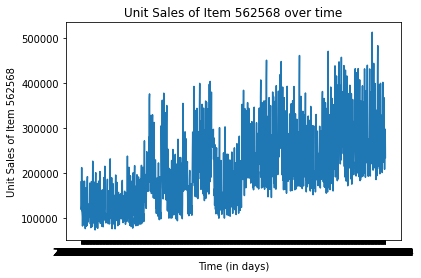

In [11]:
# sample function call
type_num = 'A'

plot_one_item(get_most_popular_item(get_type_sales(type_num)), True, type_num)

#### `construct_predictor_vectors` function

Contains `construct_predictor_vectors` function implementation.

Used in `preprocess` function.

In [12]:
# construct_predictor_vectors - takes in the X_data, the y_data, and the num_days (50) to create linreg feature vectors

def construct_predictor_vectors(X_data, y_data, seq_length):
  num_examples = X_data.shape[0] - seq_length

  X = np.zeros((num_examples, seq_length, X_data.shape[1]))
  y = np.zeros((num_examples, y_data.shape[1]))

  for i in range(num_examples):
    X[i, :, :] = X_data[i : i + seq_length, :]
    y[i,:] = y_data[i + seq_length - 1, :]

  X = np.reshape(X, (X.shape[0], X.shape[1]))
  y = np.reshape(y, (y.shape[0], y.shape[1]))

  return (X, y)

#### `preprocess`

Creates `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test` feature arrays.

**This is the main pre-processing function.**

In [18]:
# create_feature_vector_type - multiple stores, single item
# inputs: type and item numbers, days_in_future, and num_past (how many days in the past we look at for data)
# outputs: linreg-ready vectors with onpromotion and store_nbr as a feature

def create_feature_vector_type_no_rescale(type_nbr, test_store, item_nbr, days_in_future, num_past):

  # creating dataframe with data from a specific type of stores and a specific item
  df = get_type_sales(type_nbr)
  df = df[df['item_nbr'] == item_nbr]

  # defining this for one-hot coding of store numbers
  i = 0

  # master lists -- contain x & y and train & test for each store
  X_train_list = []
  X_test_list = []
  y_train_list = []
  y_test_list = []

  # capturing the test_dates so we can return it --> use for story plots
  train_dates_list = []
  test_dates_list = []

  # capturing store numbers to put in the dataframe
  train_store_nbr_list = []
  test_store_nbr_list = []

  # creating a list of stores to loop through
  loop_stores = [test_store]
  
  for store in df['store_nbr'].unique():
    if store != test_store:
      loop_stores.append(store)

  # creating restriction days for the test_store
  min_train_date = ""
  max_train_date = ""

  for store in loop_stores: # looping through all stores

    # using this as train-test split
    test_split = 0.20

    # creating a df for this particular store
    temp_df = df[df['store_nbr'] == store]

    # removing all dates that are not within the limits
    # these limits are established by the training section of test_store
    if store != test_store:
      temp_df = temp_df[temp_df['date'] <= max_train_date]

    # Filling the NaN values with False
    temp_df = temp_df.fillna(False, axis=1)

    # changing False to 0 and True to 1
    temp_df['onpromotion'] = temp_df['onpromotion'].map({False:0, True:1})

    # getting dates
    temp_dates = np.array(temp_df['date'].unique())[0:-1 * days_in_future]  

    # getting sales by day
    temp_df = temp_df.groupby(['date']).sum()

    # sorting the df by day
    temp_df.sort_values(by=['date'])

    # creating store and promo arrays
    store_arr = np.array(temp_df['store_nbr'])
    promo_arr = np.array(temp_df['onpromotion'])

    # FOCUSING ON THE SALES

    # dropping all not needed columns
    temp_df = temp_df[['unit_sales']]

    # creating a labels dataframe
    labels = temp_df.shift(-1 * days_in_future)

    # Creating X and y features
    X = np.array(temp_df['unit_sales'])[0:-1 * days_in_future]
    y = np.array(labels['unit_sales'])[0:-1 * days_in_future]

    # FOCUSING ON THE STORES
    
    if (len(temp_df) - days_in_future - num_past) > 0:

      # reshaping the data to rescale
      X = np.reshape(X, (X.shape[0], 1))
      y = np.reshape(y, (y.shape[0], 1))

      # rescaling the data between 0 and 1
      x_scaler = MinMaxScaler()
      # X_res = x_scaler.fit_transform(X)
      X_res = X

      y_scaler = MinMaxScaler()
      # y_res = y_scaler.fit_transform(y)
      y_res = y

      # one-hot encoding stores
      store_arr_1h = np.zeros((len(temp_df) - days_in_future - num_past, len(df['store_nbr'].unique())))
      for j in range(len(temp_df) - days_in_future - num_past):
        store_arr_1h[j][i] = 1

      test_amount = math.ceil((len(X_res) - num_past) * test_split)
          
      # MERGING THE SALES, STORES, AND PROMO TOGETHER
      
      if test_amount > num_past: # this prevents us from getting negative numbers in the numpy array

        # removing the last num_past values for dates
        temp_dates = temp_dates[:-num_past]

        # splitting the dates into train and test
        train_dates = temp_dates[0:-1 * test_amount]
        test_dates = temp_dates[-1 * test_amount:]
        
        if store == test_store:
          min_train_date = train_dates[0]
          max_train_date = train_dates[-1]
        
        # else:
        #   for i in range(len(train_dates)):
        #     if train_dates[i] < min_train_date or train_dates[i] > max_train_date:
        #       np.delete(train_dates, i)

        # appending to the master date lists
        train_dates_list.append(train_dates)        

        # splitting the stores into train and test
        store_train = store_arr_1h[0:-1 * test_amount, :]
        store_test = store_arr_1h[-1 * test_amount:, :]
      
        # FOCUSING ON THE PROMO

        # shifting the promo values, as we did to the labels for unit_sales
        promo_arr = np.roll(promo_arr, -1 * days_in_future)

        # removing the last days_in_future values
        promo_arr = promo_arr[0:-1 * days_in_future]

        # removing the last num_past values
        promo_arr = promo_arr[:-num_past]

        # splitting the promo values into train and test
        promo_train = promo_arr[0:-1 * test_amount]
        promo_test = promo_arr[-1 * test_amount:]

        # constructing the predictor vectors
        X_vec, y_vec = construct_predictor_vectors(X_res, y_res, num_past)

        # splitting into train and test -- 80-20 split of train-test
        X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, shuffle=False, test_size=test_split)
        

        # reshaping the promos to put them together with sales
        promo_train = np.reshape(promo_train, (promo_train.shape[0], 1))
        promo_test = np.reshape(promo_test, (promo_test.shape[0], 1))

        # putting the promos and sales together
        X_feature_train = np.concatenate((X_train, promo_train), axis=1)
        X_feature_test = np.concatenate((X_test, promo_test), axis=1)

        # putting the store number and sales & promos together
        X_feature_train = np.concatenate((X_feature_train, store_train), axis=1)
        X_feature_test = np.concatenate((X_feature_test, store_test), axis=1)

               
        # appending to the master lists
        X_train_list.append(X_feature_train)
        y_train_list.append(y_train)

        # adding to the store list
        train_store_nbr_list.append(np.ones(len(X_train)) * store)

        if store == test_store:
          X_test_list.append(X_feature_test)
          y_test_list.append(y_test)
          test_dates_list.append(test_dates)

    else:
      continue
      # raise Exception("There is not enough data to construct feature vectors for store " + str(store))
  
  if len(X_train_list) > 0 and len(X_test_list) > 0:

    # creating global x & y and train & test
    X_train = X_train_list[0]
    y_train = y_train_list[0]

    X_test = X_test_list[0]
    y_test = y_test_list[0]
   
    # concatenating all the data together
    for i in range(1, len(X_train_list)):
      X_train = np.concatenate((X_train, X_train_list[i]), axis=0)
      y_train = np.concatenate((y_train, y_train_list[i]), axis=0)

    # concatenating all the dates together
    train_dates_concat = np.array(train_dates_list[0])
    test_dates_concat = np.array(test_dates_list[0])

    for i in range(1, len(train_dates_list)):
      train_dates_concat = np.concatenate((train_dates_concat, train_dates_list[i]), axis=0)
  
    # concatenating all the train store_nbrs together
    store_train_concat = np.array(train_store_nbr_list[0])

    for i in range(1, len(train_store_nbr_list)):
      store_train_concat = np.concatenate((store_train_concat, train_store_nbr_list[i]), axis=0)
    
    # randomize the data

    np.random.seed(10)
    np.random.shuffle(X_train)
    np.random.seed(10)
    np.random.shuffle(y_train)
    np.random.seed(10)
    np.random.shuffle(train_dates_concat)
    np.random.seed(10)
    np.random.shuffle(store_train_concat)

    # creating list of test_stores
    store_nbr_list = np.ones(len(test_dates_concat)) * test_store

    # creating new reshaped arrays for the dataframe

    # train
    train_dates_concat_df = np.reshape(train_dates_concat, (train_dates_concat.shape[0]))
    store_train_concat_df = np.reshape(store_train_concat, (store_train_concat.shape[0]))
    y_train_df = np.reshape(y_train, (y_train.shape[0]))

    # test
    test_dates_concat_df = np.reshape(test_dates_concat, (test_dates_concat.shape[0]))
    store_nbr_list_df = np.reshape(store_nbr_list, (store_nbr_list.shape[0]))
    y_test_df = np.reshape(y_test, (y_test.shape[0]))

    # creating the dictionaries
    ml_train_dict = {
        'features': [],
        'date': train_dates_concat_df,
        'store_nbr': store_train_concat_df,
        'labels': y_train_df
    }

    ml_test_dict = {
        'features': [],
        'date': test_dates_concat_df,
        'store_nbr': store_nbr_list_df,
        'labels': y_test_df
    }

    # going through all the X_train's and adding the feature vectors to the dictionary
    for i in range(X_train.shape[0]):
      temp_feature_vector = X_train[i]
      temp_feature_vector = np.reshape(temp_feature_vector, (temp_feature_vector.shape[0]))
      temp_feature_vector = list(temp_feature_vector)
      ml_train_dict['features'].append(temp_feature_vector)
    
    # going through all the X_test's and adding the feature vectors to the dictionary
    for i in range(X_test.shape[0]):
      temp_feature_vector = X_test[i]
      temp_feature_vector = np.reshape(temp_feature_vector, (temp_feature_vector.shape[0]))
      ml_test_dict['features'].append(temp_feature_vector)

    # creating the dataframes
    ml_train = pd.DataFrame(ml_train_dict)
    ml_test = pd.DataFrame(ml_test_dict)

    return X_train, X_test, y_train, y_test, ml_train, ml_test
  else:
    #return np.zeros(0), 0, 0, 0, 0, 0
    return np.zeros(0), np.zeros(0), 0, 0, 0, 0

In [21]:
# preprocess - multiple stores, single item
# inputs: type and item numbers, days_in_future, and num_past (how many days in the past we look at for data)
# outputs: linreg-ready vectors with onpromotion and store_nbr as a feature

def preprocess(type_nbr, test_store, item_nbr, days_in_future, num_past):

  # creating dataframe with data from a specific type of stores and a specific item
  df = get_type_sales(type_nbr)
  df = df[df['item_nbr'] == item_nbr]

  # defining this for one-hot encoding of store numbers
  i = 0

  # master lists -- contain x & y and train & test for each store
  X_train_list = []
  X_test_list = []
  y_train_list = []
  y_test_list = []

  # capturing the test_dates so we can return it --> use for story plots
  train_dates_list = []
  test_dates_list = []

  # capturing store numbers to put in the dataframe
  train_store_nbr_list = []
  test_store_nbr_list = []

  # creating a list of stores to loop through
  loop_stores = [test_store]
  
  for store in df['store_nbr'].unique():
    if store != test_store:
      loop_stores.append(store)

  # creating restriction days for the test_store
  min_train_date = ""
  max_train_date = ""

  for store in loop_stores: # looping through all stores

    # using this as train-test split
    test_split = 0.30

    # creating a df for this particular store
    temp_df = df[df['store_nbr'] == store]

    # removing all dates that are not within the limits
    # these limits are established by the training section of test_store
    if store != test_store:
      temp_df = temp_df[temp_df['date'] <= max_train_date]

    # Filling the NaN values with False
    temp_df = temp_df.fillna(False, axis=1)

    # changing False to 0 and True to 1
    temp_df['onpromotion'] = temp_df['onpromotion'].map({False:0, True:1})

    # getting dates
    temp_dates = np.array(temp_df['date'].unique())[0:-1 * days_in_future]  

    # getting sales by day
    temp_df = temp_df.groupby(['date']).sum()

    # sorting the df by day
    temp_df.sort_values(by=['date'])

    # creating store and promo arrays
    store_arr = np.array(temp_df['store_nbr'])
    promo_arr = np.array(temp_df['onpromotion'])

    # FOCUSING ON THE SALES

    # dropping all not needed columns
    temp_df = temp_df[['unit_sales']]

    # creating a labels dataframe
    labels = temp_df.shift(-1 * days_in_future)

    # Creating X and y features
    X = np.array(temp_df['unit_sales'])[0:-1 * days_in_future]
    y = np.array(labels['unit_sales'])[0:-1 * days_in_future]

    # FOCUSING ON THE STORES
    
    if (len(temp_df) - days_in_future - num_past) > 0:

      # reshaping the data to rescale
      X = np.reshape(X, (X.shape[0], 1))
      y = np.reshape(y, (y.shape[0], 1))

      # rescaling the data between 0 and 1
      x_scaler = MinMaxScaler()
      # X_res = x_scaler.fit_transform(X)
      X_res = X

      y_scaler = MinMaxScaler()
      # y_res = y_scaler.fit_transform(y)
      y_res = y

      # one-hot encoding stores
      store_arr_1h = np.zeros((len(temp_df) - days_in_future - num_past, len(df['store_nbr'].unique())))
      for j in range(len(temp_df) - days_in_future - num_past):
        store_arr_1h[j][i] = 1

      test_amount = math.ceil((len(X_res) - num_past) * test_split)
          
      # MERGING THE SALES, STORES, AND PROMO TOGETHER
      
      if test_amount > num_past: # this prevents us from getting negative numbers in the numpy array

        # removing the last num_past values for dates
        temp_dates = temp_dates[:-num_past]

        # splitting the dates into train and test
        train_dates = temp_dates[0:-1 * test_amount]
        test_dates = temp_dates[-1 * test_amount:]
        
        if store == test_store:
          min_train_date = train_dates[0]
          max_train_date = train_dates[-1]
        
        # else:
        #   for i in range(len(train_dates)):
        #     if train_dates[i] < min_train_date or train_dates[i] > max_train_date:
        #       np.delete(train_dates, i)

        # appending to the master date lists
        train_dates_list.append(train_dates)        

        # splitting the stores into train and test
        store_train = store_arr_1h[0:-1 * test_amount, :]
        store_test = store_arr_1h[-1 * test_amount:, :]
      
        # FOCUSING ON THE PROMO

        # shifting the promo values, as we did to the labels for unit_sales
        promo_arr = np.roll(promo_arr, -1 * days_in_future)

        # removing the last days_in_future values
        promo_arr = promo_arr[0:-1 * days_in_future]

        # removing the last num_past values
        promo_arr = promo_arr[:-num_past]

        # splitting the promo values into train and test
        promo_train = promo_arr[0:-1 * test_amount]
        promo_test = promo_arr[-1 * test_amount:]

        # constructing the predictor vectors
        X_vec, y_vec = construct_predictor_vectors(X_res, y_res, num_past)

        # splitting into train and test -- 80-20 split of train-test
        X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, shuffle=False, test_size=test_split)
        

        # reshaping the promos to put them together with sales
        promo_train = np.reshape(promo_train, (promo_train.shape[0], 1))
        promo_test = np.reshape(promo_test, (promo_test.shape[0], 1))

        # putting the promos and sales together
        X_feature_train = np.concatenate((X_train, promo_train), axis=1)
        X_feature_test = np.concatenate((X_test, promo_test), axis=1)

        # putting the store number and sales & promos together
        X_feature_train = np.concatenate((X_feature_train, store_train), axis=1)
        X_feature_test = np.concatenate((X_feature_test, store_test), axis=1)

               
        # appending to the master lists
        X_train_list.append(X_feature_train)
        y_train_list.append(y_train)

        # adding to the store list
        train_store_nbr_list.append(np.ones(len(X_train)) * store)

        if store == test_store:
          X_test_list.append(X_feature_test)
          y_test_list.append(y_test)
          test_dates_list.append(test_dates)

    else:
      continue
      # raise Exception("There is not enough data to construct feature vectors for store " + str(store))
  
  if len(X_train_list) > 0 and len(X_test_list) > 0:

    # creating global x & y and train & test
    X_train = X_train_list[0]
    y_train = y_train_list[0]

    X_test = X_test_list[0]
    y_test = y_test_list[0]
   
    # concatenating all the data together
    for i in range(1, len(X_train_list)):
      X_train = np.concatenate((X_train, X_train_list[i]), axis=0)
      y_train = np.concatenate((y_train, y_train_list[i]), axis=0)

    # concatenating all the dates together
    train_dates_concat = np.array(train_dates_list[0])
    test_dates_concat = np.array(test_dates_list[0])

    for i in range(1, len(train_dates_list)):
      train_dates_concat = np.concatenate((train_dates_concat, train_dates_list[i]), axis=0)
  
    # concatenating all the train store_nbrs together
    store_train_concat = np.array(train_store_nbr_list[0])

    for i in range(1, len(train_store_nbr_list)):
      store_train_concat = np.concatenate((store_train_concat, train_store_nbr_list[i]), axis=0)
    
    # randomize the data

    np.random.seed(10)
    np.random.shuffle(X_train)
    np.random.seed(10)
    np.random.shuffle(y_train)
    np.random.seed(10)
    np.random.shuffle(train_dates_concat)
    np.random.seed(10)
    np.random.shuffle(store_train_concat)

    # creating list of test_stores
    store_nbr_list = np.ones(len(test_dates_concat)) * test_store

    # creating new reshaped arrays for the dataframe

    # train
    train_dates_concat_df = np.reshape(train_dates_concat, (train_dates_concat.shape[0]))
    store_train_concat_df = np.reshape(store_train_concat, (store_train_concat.shape[0]))
    y_train_df = np.reshape(y_train, (y_train.shape[0]))

    # test
    test_dates_concat_df = np.reshape(test_dates_concat, (test_dates_concat.shape[0]))
    store_nbr_list_df = np.reshape(store_nbr_list, (store_nbr_list.shape[0]))
    y_test_df = np.reshape(y_test, (y_test.shape[0]))

    # creating the dictionaries
    ml_train_dict = {
        'features': [],
        'date': train_dates_concat_df,
        'store_nbr': store_train_concat_df,
        'label': y_train_df
    }

    ml_test_dict = {
        'features': [],
        'date': test_dates_concat_df,
        'store_nbr': store_nbr_list_df,
        'label': y_test_df
    }

    # going through all the X_train's and adding the feature vectors to the dictionary
    for i in range(X_train.shape[0]):
      temp_feature_vector = X_train[i]
      temp_feature_vector = np.reshape(temp_feature_vector, (temp_feature_vector.shape[0]))
      temp_feature_vector = list(temp_feature_vector)
      ml_train_dict['features'].append(temp_feature_vector)
    
    # going through all the X_test's and adding the feature vectors to the dictionary
    for i in range(X_test.shape[0]):
      temp_feature_vector = X_test[i]
      temp_feature_vector = np.reshape(temp_feature_vector, (temp_feature_vector.shape[0]))
      ml_test_dict['features'].append(temp_feature_vector)

    # creating the dataframes
    ml_train = pd.DataFrame(ml_train_dict)
    ml_test = pd.DataFrame(ml_test_dict)

    X_val, X_test, y_val, y_test = np.array_split(X_test, 2)[0], np.array_split(X_test, 2)[1], np.array_split(y_test, 2)[0], np.array_split(y_test, 2)[1]
    ml_val, ml_test = np.array_split(ml_test, 2)[0], np.array_split(ml_test, 2)[1]

    return X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test
  else:
    return np.zeros(0), np.zeros(0), 0, 0, 0, 0, 0, 0, 0

In [22]:
X_train, X_test, y_train, y_test, ml_train, ml_test = create_feature_vector_type_no_rescale('A', 49, 103665, 7, 25)
print('Len of 1st X_train:', len(X_train))
print('Len of 1st X_test:', len(X_test))
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess('A', 49, 103665, 7, 25)
print('Len of 2nd X_train:', len(X_train))
print('Len of X_val:', len(X_val))
print('Len of 2nd X_test:', len(X_test))

Len of 1st X_train: 6812
Len of 1st X_test: 257
Len of 2nd X_train: 5331
Len of X_val: 193
Len of 2nd X_test: 193


### Error Metrics

#### `MAPE` function

Calculates the MAPE with given `y_true` and `y_pred` NumPy arrays.

In [13]:
def mape_func(y_pred, labels, eps=0.001):
  """
  Computes the MAPE given the labels and predictions.
  """

  adj_labels = np.clip(abs(labels), eps, np.max(abs(labels)))
  raw_pe = 100 * abs((adj_labels - y_pred)/abs(adj_labels))
  adj_pe = np.clip(raw_pe, 0, 1/eps) # 1/eps is the maximum contribution

  mape = np.mean(adj_pe)

  return mape

#### RMSLE function

In [24]:
from sklearn.metrics import mean_squared_log_error

def rmsle(y_test, preds):

  i = 0

  while i < len(y_test):
    if y_test[i] < 0:
      y_test = np.delete(y_test, i, 0)
      preds = np.delete(preds, i, 0)

    j = 0
    while i <= len(preds) - 1 and j < len(preds[i]):
      if preds[i][j] < 0:
        preds = np.delete(preds, i, 0)
        y_test = np.delete(y_test, i, 0)
      
      j += 1
    i += 1

  return np.sqrt(mean_squared_log_error(y_test, preds))

# ML Models

### 90 Testing Items

First, get all 90 items which we test on.

In [27]:
# find all perishable items
# find all items in the family
# decrease the dataframe to just that store
# decrease the dataframe so that it contains items that are in the family
# go through all the items and find their average daily sales in temp_df
# add the item number and average daily sales into a dictionary
# sort this dictionary by value (and reverse it)
# calculate the number of items this family needs to add - len(temp_df_items) / 986 = x / len(items_sorted)

def create_family_items(family, store_input_nbr, total_len_items=100):

  perishable_df = items_df[items_df['perishable'] == 1]
  perishable_df = perishable_df[perishable_df['family'] == family]
  family_items = perishable_df['item_nbr']

  temp_df = train[train['store_nbr'] == store_input_nbr]
  temp_df = temp_df[temp_df['item_nbr'].isin(family_items)]
  temp_df_items = np.array(temp_df['item_nbr'].unique())

  item_sales_dict = {}

  for i in range(len(temp_df_items)):
    temp_df_item = temp_df[temp_df['item_nbr'] == temp_df_items[i]]

    temp_df_item = temp_df_item.groupby(['date']).sum()

    mean_sales = np.mean(np.array(temp_df_item['unit_sales']))

    item_sales_dict[temp_df_items[i]] = mean_sales

  items_sorted = sorted(item_sales_dict, key=lambda x: item_sales_dict[x], reverse=True)

  perishable_df = items_df[items_df['perishable'] == 1]

  all_perishables = np.array(perishable_df['item_nbr'].unique())

  temp_store_df = train[train['store_nbr'] == store_input_nbr]

  temp_store_df = temp_store_df[temp_store_df['item_nbr'].isin(all_perishables)]

  temp_store_perishables = len(temp_store_df['item_nbr'].unique())

  family_items = items_df[items_df['family'] == family]
  family_items = np.array(family_items['item_nbr'])

  unique_store_items = np.array(temp_store_df['item_nbr'].unique())

  temp_family_store_perishables = 0

  for i in range(len(unique_store_items)):
    if unique_store_items[i] in family_items:
      temp_family_store_perishables += 1
  
  num_items_for_family = int((temp_family_store_perishables * 100) / temp_store_perishables)

  return items_sorted[:num_items_for_family]

In [28]:
# Next, we need to grab 90 highest-selling items on which we will run both linear regression and decision tree models

perishable_df = items_df[items_df['perishable'] == 1]
perishable_families = np.array(perishable_df['family'].unique())
store_input_nbr = 49

comparison_items = []
family_items = []

for family in (perishable_families):

  comparison_items += create_family_items(family, store_input_nbr, 100)
  family_items += create_family_items(family, store_input_nbr, 100)

test_items = comparison_items
len(test_items)

95

## Baselines

### Predicting the Previous Day

Defining the function we will use to get the previous day's predictions.

In [31]:
# baseline_prev_day - baseline model that uses the previous day's sales to make predictions
# inputs - X_test, y_test, num_past
# outputs - preds, mse

def baseline_prev_day(X_test, y_test, num_past):
  # defining some variables

  num_test_examples = y_test.shape[0]
  predict_index = num_past - 1
  labels = y_test

  # making predictions
  preds = []

  for i in range(num_test_examples):
    preds.append(X_test[i][predict_index])

  # reshaping preds and labels
  preds = np.array(preds)
  test_preds = np.reshape(preds, (preds.shape[0], 1))
  labels = np.reshape(labels, (labels.shape[0], 1)) 

  # calculating mse, mae, and mape
  mse = mean_squared_error(labels, test_preds)
  mae = mean_absolute_error(labels, test_preds)
  mape = mape_func(test_preds, labels)
  
  return test_preds, mse, mae, mape, labels

#### Exploring Results of One Item

First, we need to get the predictions.

In [32]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
item_inp = 1503844 # highest-selling item
num_past_inp = 25
days_in_future_inp = 7

# getting data
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item_inp, days_in_future_inp, num_past_inp)

# getting predictions
prev_day_preds, prev_day_mse, prev_day_mae, prev_day_mape, prev_day_labels = baseline_prev_day(X_val, y_val, num_past_inp)

Then, we need to figure out our error metrics.

In [33]:
# calculating MAPE and RMSLE
prev_day_mape = prev_day_mape
prev_day_rmsle = rmsle(prev_day_labels, prev_day_preds)

# printing MAPE and RMSLE
print('The MAPE was: '+ str(round(prev_day_mape, 2)) + '%')
print('The RMSLE was: '+ str(round(prev_day_rmsle, 2)))

The MAPE was: 25.05%
The RMSLE was: 0.32


Now, we can plot the predictions against the labels.

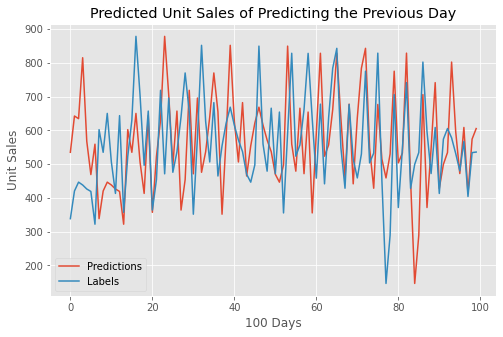

In [35]:
# setting variable names
num_days_plot = 100

# plot settings
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
plt.xlabel(str(num_days_plot) + ' Days')
plt.ylabel('Unit Sales')
plt.title('Predicted Unit Sales of Predicting the Previous Day')

# plotting the arrays
plt.plot(prev_day_preds[:num_days_plot], label='Predictions')
plt.plot(prev_day_labels[:num_days_plot], label='Labels')
plt.legend()
plt.show()

#### Recording Results of All Items

In [ ]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
num_past_inp = 25
days_in_future_inp = 7

# creating a dictionary to store data
baseline_prev_day_dict = {'item_nbr': [], 'baseline_prev_day_mape': [], 'baseline_prev_day_rmsle': []}

# looping through all items
for item in tqdm(test_items):

  # getting the data
  X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item, days_in_future_inp, num_past_inp)

  if X_train.size != 0:

    # making predictions
    prev_day_preds, prev_day_mse, prev_day_mae, prev_day_mape, prev_day_labels = baseline_prev_day(X_test, y_test, num_past_inp)

    # calculating error metrics
    prev_day_mape = prev_day_mape
    prev_day_rmsle = rmsle(prev_day_labels, prev_day_preds)

    # adding to dictionary
    baseline_prev_day_dict['item_nbr'].append(item)
    baseline_prev_day_dict['baseline_prev_day_mape'].append(prev_day_mape)
    baseline_prev_day_dict['baseline_prev_day_rmsle'].append(prev_day_rmsle)

# making a dataframe
baseline_prev_day_df = pd.DataFrame(baseline_prev_day_dict)

baseline_prev_day_df.head()

100%|██████████| 95/95 [06:30<00:00,  4.11s/it]


,item_nbr,baseline_prev_day_mape,baseline_prev_day_rmsle
0,1333307,30.638109,0.361661
1,502331,27.303362,0.329036
2,1309246,38.986543,0.453673
3,1998005,25.139351,0.283449
4,1309245,136.967780,0.937779


In [ ]:
# Now, I will save this df to a csv in google drive

baseline_prev_day_df.to_csv('baseline_prev_day_results.csv')
!cp baseline_prev_day_results.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results/Testing Results - 14 Days"

### EWMA

We need to define the function we will use to make predictions.

In [36]:
# ewma_baseline - computes the ewma
# input: X_train, X_test, y_train, y_test
# ouputs: preds, labels (unit_sales), mse

def ewma_baseline(X_test, y_test, y_rescaler=0):
  preds = []
  for i in range(len(X_test)):
    row = np.array(X_test[i])
    single_test_example_df = pd.DataFrame({'unit_sales': row})
    temp = np.array(single_test_example_df.ewm(com=X_test.shape[0]/2).mean()) # divide by 2 because that makes the center of mass the middle of X_test
    preds.append(temp[len(temp) - 1])

  # making sure the preds and labels are the same length
  preds = np.array(preds)
  preds = np.reshape(preds, (preds.shape[0], 1))

  if type(y_rescaler) != int:
    labels = y_rescaler.inverse_transform(y_test)
    preds = y_rescaler.inverse_transform(preds)
  else:
    labels = y_test

  # calculating mse, mae, and mape
  mse = mean_squared_error(labels, preds)
  mae = mean_absolute_error(labels, preds)
  mape = mape_func(preds, labels)

  return preds, mse, mae, mape, labels

# setting variables for parameters
item_input_nbr = 1926217
type_input_nbr = 'A'
days_in_future_input = 7
num_past_input = 25
ewma_num_past_input = 15
store_nbr_input = 49

# getting all preds and mse
X_train, X_test, y_train, y_test, ml_train, ml_test = create_feature_vector_type_no_rescale(type_input_nbr, store_nbr_input, item_input_nbr, days_in_future_input, num_past_input)
ewma_preds, ewma_mse, ewma_mae, ewma_mape, ewma_labels = ewma_baseline(X_test, y_test)

print(ewma_mape)

32.27741266473564


#### Exploring Results of One Item

First, we need to get the predictions.

In [37]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
item_inp = 1503844 # highest-selling item
num_past_inp = 25
days_in_future_inp = 7

# getting data
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item_inp, days_in_future_inp, num_past_inp)

# getting predictions
ewma_preds, ewma_mse, ewma_mae, ewma_mape, ewma_labels = ewma_baseline(X_val, y_val)

Then, we need to figure out our error metrics.

In [38]:
# calculating MAPE and RMSLE
ewma_mape = ewma_mape
ewma_rmsle = rmsle(ewma_labels, ewma_preds)

# printing MAPE and RMSLE
print('The MAPE was: '+ str(round(ewma_mape, 2)) + '%')
print('The RMSLE was: '+ str(round(ewma_rmsle, 2)))

The MAPE was: 33.3%
The RMSLE was: 0.48


Now, we can plot the predictions against the labels.

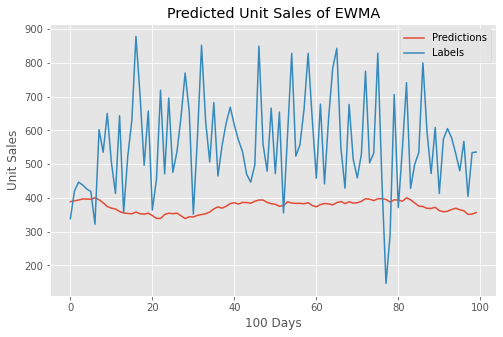

In [40]:
# setting variable names
num_days_plot = 100

# plot settings
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
plt.xlabel(str(num_days_plot) + ' Days')
plt.ylabel('Unit Sales')
plt.title('Predicted Unit Sales of EWMA')

# plotting the arrays
plt.plot(ewma_preds[:num_days_plot], label='Predictions')
plt.plot(ewma_labels[:num_days_plot], label='Labels')
plt.legend()
plt.show()

#### Recording Results of All Items

In [ ]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
num_past_inp = 25
days_in_future_inp = 7

# creating a dictionary to store data
ewma_dict = {'item_nbr': [], 'ewma_mape': [], 'ewma_rmsle': []}

# looping through all items
for item in tqdm(test_items):

  # getting the data
  X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item, days_in_future_inp, num_past_inp)

  if X_train.size != 0:

    # making predictions
    ewma_preds, ewma_mse, ewma_mae, ewma_mape, ewma_labels = ewma_baseline(X_test, y_test)

    # removing the bad data
    if item == 1503844:
      for i in range(len(y_test)):
        if y_test[i][0] < 1:
          ewma_preds = np.delete(ewma_preds, i, 0)
          ewma_labels = np.delete(y_test, i, 0)

    # calculating error metrics
    ewma_mape_adjusted = mape_func(ewma_preds, ewma_labels)
    ewma_rmsle = rmsle(ewma_labels, ewma_preds)

    # adding to dictionary
    ewma_dict['item_nbr'].append(item)
    ewma_dict['ewma_mape'].append(ewma_mape_adjusted)
    ewma_dict['ewma_rmsle'].append(ewma_rmsle)

# making a dataframe
ewma_df = pd.DataFrame(ewma_dict)

ewma_df.head()


100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


,item_nbr,ewma_mape,ewma_rmsle
0,1503844,34.419302,0.476761


In [ ]:
# Now, I will save this df to a csv in google drive

ewma_df.to_csv('ewma_results.csv')
!cp ewma_results.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results/Testing Results - 14 Days"

## Autoregressive Models

### Least-Squares Linear Regression

No regularization yet.

First, we need to define the function we will use to get results.

In [41]:
# linreg_model -- returns predictions and mse of a linreg model
# inputs: X_train, X_test, y_train, y_test
# outputs: preds, mse


def linreg_model(X_train, X_test, y_train, y_test, y_rescaler=0):

  # linear regression model
  model = LinearRegression()
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  if type(y_rescaler) != int:
    # unscaling the preds and labels
    labels = y_rescaler.inverse_transform(y_test)
    preds = y_rescaler.inverse_transform(preds)
  
  else:
    labels = y_test

  # calculating mse, mae, and mape
  mse = mean_squared_error(labels, preds)
  mae = mean_absolute_error(labels, preds)
  mape = mape_func(preds, labels)
  
  return preds, mse, mae, mape, labels

#### Running on One Item

First, we need to make the predictions.

In [42]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
item_inp = 1503844 # highest-selling item
num_past_inp = 25
days_in_future_inp = 7

# getting data
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item_inp, days_in_future_inp, num_past_inp)

# making predictions
ln = LinearRegression()
ln.fit(X_train, y_train)
ln_train_preds = ln.predict(X_train)
ln_val_preds = ln.predict(X_val)

Then, we need to figure out error metrics.

In [43]:
# getting error metrics
ln_train_preds_reshaped = np.reshape(ln_train_preds, (ln_train_preds.shape[0]))
ln_train_labels = np.reshape(y_train, (y_train.shape[0]))

ln_train_mape = mape_func(ln_train_preds_reshaped, ln_train_labels)
ln_val_mape = mape_func(ln_val_preds, y_val)
ln_train_rmsle = rmsle(y_train, ln_train_preds)
ln_val_rmsle = rmsle(y_val, ln_val_preds)

# printing val error
print('The val MAPE was: '+ str(round(ln_val_mape, 2)) + '%')
print('The val RMSLE was: '+ str(round(ln_val_rmsle, 2)))

# printing train error
print('The train MAPE was: '+ str(round(ln_train_mape, 2)) + '%')
print('The train RMSLE was: '+ str(round(ln_train_rmsle, 2)))

The val MAPE was: 23.1%
The val RMSLE was: 0.28
The train MAPE was: 26.29%
The train RMSLE was: 0.32


Then, we can plot the predictions vs. the labels.

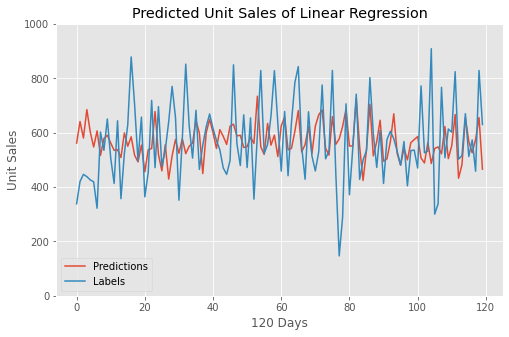

In [48]:
# setting variable names
num_days_plot = 120

# plot settings
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
plt.xlabel(str(num_days_plot) + ' Days')
plt.ylabel('Unit Sales')
plt.title('Predicted Unit Sales of Linear Regression')
plt.ylim((0, 1000))

# plotting the arrays
plt.plot(ln_val_preds[:num_days_plot], label='Predictions')
plt.plot(y_val[:num_days_plot], label='Labels')
plt.legend()
plt.show()

#### Running on All Items

In [ ]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
num_past_inp = 25
days_in_future_inp = 7

# creating a dictionary to store data
linreg_dict = {'item_nbr': [], 'linreg_train_mape': [], 'linreg_train_rmsle': [], 'linreg_val_mape': [], 'linreg_val_rmsle': [], 'linreg_test_mape': [], 'linreg_test_rmsle': []}

# looping through all items
for item in tqdm(test_items):

  # getting the data
  X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item, days_in_future_inp, num_past_inp)

  if X_train.size != 0:

    # creating a model and fitting it
    ln = LinearRegression()
    ln.fit(X_train, y_train)

    # making predictions
    ln_train_preds = ln.predict(X_train)
    ln_val_preds = ln.predict(X_val)
    ln_test_preds = ln.predict(X_test)

    # removing the bad data
    if item == 1503844:
      for i in range(len(y_test)):
        if y_test[i][0] < 1:
          ln_test_preds = np.delete(ln_test_preds, i, 0)
          y_test = np.delete(y_test, i, 0)
          break

    # calculating error metrics
    ln_train_mape = mape_func(ln_train_preds, y_train)
    ln_val_mape = mape_func(ln_val_preds, y_val)
    ln_test_mape = mape_func(ln_test_preds, y_test)
    ln_train_rmsle = rmsle(y_train, ln_train_preds)
    ln_val_rmsle = rmsle(y_val, ln_val_preds)
    ln_test_rmsle = rmsle(y_test, ln_test_preds)

    # adding to dictionary
    linreg_dict['item_nbr'].append(item)
    linreg_dict['linreg_train_mape'].append(ln_train_mape)
    linreg_dict['linreg_train_rmsle'].append(ln_train_rmsle)
    linreg_dict['linreg_val_mape'].append(ln_val_mape)
    linreg_dict['linreg_val_rmsle'].append(ln_val_rmsle)
    linreg_dict['linreg_test_mape'].append(ln_test_mape)
    linreg_dict['linreg_test_rmsle'].append(ln_test_rmsle)

# making a dataframe
linreg_df = pd.DataFrame(linreg_dict)

linreg_df.head()


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]


,item_nbr,linreg_train_mape,linreg_train_rmsle,linreg_val_mape,linreg_val_rmsle,linreg_test_mape,linreg_test_rmsle
0,1503844,26.28501,0.316737,23.101611,0.277028,24.499533,0.292815


In [ ]:
# Now, I will save this df to a csv in google drive

linreg_df.to_csv('linreg_results.csv')
!cp linreg_results.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results/Testing Results - 14 Days"

### Lasso Regression

#### Running on One Item

First, we need to load in the data.

In [53]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
item_inp = 1503844
num_past_inp = 25
days_in_future_inp = 7

# getting data
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item_inp, days_in_future_inp, num_past_inp)

Next, we can try to explore which values of alpha result in a lower MAPE.

In [54]:
# creating useful lists
alpha = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60, 75, 90, 100, 500, 1000, 2000, 3000]
# coefs = []
# preds = []
# intercepts = []
alpha_mape_dict = {}

# going through all alphas
for alpha_value in alpha:

  # fitting the model
  model = linear_model.Lasso(alpha=alpha_value, max_iter=5000)
  model.fit(X_train, y_train)

  # making predictions, calculating error metrics
  train_preds = model.predict(X_train)
  train_preds = np.reshape(train_preds, (train_preds.shape[0], 1))
  temp_alpha_mape = mape_func(train_preds, y_train)

  # adding alpha and mape to dict
  alpha_mape_dict[alpha_value] = temp_alpha_mape

In [55]:
alpha_mape_dict

{0.001: 26.284924630858963,
 0.01: 26.284158042663382,
 0.05: 26.280775049983383,
 0.1: 26.276914489373453,
 0.5: 26.250980418540646,
 1: 26.231821284703194,
 2: 26.263366202741626,
 5: 26.263773446396666,
 10: 26.264400138828034,
 20: 26.2658898081431,
 30: 26.267151995098995,
 40: 26.26899620557834,
 50: 26.271505657889627,
 60: 26.27277723973119,
 75: 26.277343964178936,
 90: 26.282473206510314,
 100: 26.286607693992067,
 500: 26.5449477125042,
 1000: 26.884129230066524,
 2000: 27.650985386160396,
 3000: 28.52287197691638}

Comparing to normal least-squares linear regression.

In [56]:
ln = LinearRegression()
ln.fit(X_train, y_train)
normal_train_preds = ln.predict(X_train)
normal_train_preds = np.reshape(normal_train_preds, (normal_train_preds.shape[0], 1))

print(mape_func(normal_train_preds, y_train))

26.285009808686052


#### Running on All Items

In [ ]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
num_past_inp = 25
days_in_future_inp = 7

# dict to store data
lasso_reg_dict = {'item_nbr': [], 'lasso_mape': [], 'lasso_rmsle': [], 'lasso_mae': []}

# looping through all items
for item in tqdm(test_items):

  # getting data
  X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item, days_in_future_inp, num_past_inp)

  if X_train.size != 0:

    # TESTING ALPHAS
    alpha = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60, 75, 90, 100, 500, 1000, 2000, 3000]
    alpha_mape_dict = {}

    # going through all alphas
    for alpha_value in alpha:

      # fitting the model
      model = linear_model.Lasso(alpha=alpha_value, max_iter=5000)
      model.fit(X_train, y_train)

      # making predictions, calculating error metrics
      train_preds = model.predict(X_train)
      train_preds = np.reshape(train_preds, (train_preds.shape[0], 1))
      temp_alpha_mape = mape_func(train_preds, y_train)

      # adding alpha and mape to dict
      alpha_mape_dict[alpha_value] = temp_alpha_mape
    
    # getting the alpha which resulted in the lowest MAPE
    min_mape_alpha = min(alpha_mape_dict, key=lambda x: alpha_mape_dict[x])

    # training the model with the best alpha
    model = linear_model.Lasso(alpha=min_mape_alpha, max_iter=5000)
    model.fit(X_train, y_train)

    # making predictions
    test_preds = model.predict(X_test)

    # getting error metrics
    test_preds = np.reshape(test_preds, (test_preds.shape[0], 1))
    test_mape = mape_func(test_preds, y_test)
    test_rmsle = rmsle(y_test, test_preds)

    # getting mae
    y_test_mae = np.reshape(y_test, (y_test.shape[0]))
    test_preds_mae = np.reshape(test_preds, (test_preds.shape[0]))
    test_mae = mean_absolute_error(y_test_mae, test_preds_mae)

    # adding to dict
    lasso_reg_dict['item_nbr'].append(item)
    lasso_reg_dict['lasso_mape'].append(test_mape)
    lasso_reg_dict['lasso_rmsle'].append(test_rmsle)
    lasso_reg_dict['lasso_mae'].append(test_mae)

# converting to df
lasso_reg_df = pd.DataFrame(lasso_reg_dict)

# printing
lasso_reg_df.head()

100%|██████████| 95/95 [08:09<00:00,  5.15s/it]


,item_nbr,lasso_mape,lasso_rmsle,lasso_mae
0,1333307,21.518349,0.268023,29.873019
1,502331,22.502817,0.256606,13.692484
2,1309246,28.694593,0.322194,15.402372
3,1998005,19.685685,0.211796,9.273807
4,1309245,117.412121,0.811754,24.785837


In [ ]:
# Now, I will save this df to a csv in google drive

lasso_reg_df.to_csv('lasso_results.csv')
!cp lasso_results.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results/Testing Results - 14 Days"

### Ridge Regression

#### Running on One Item

First, we need to load in the data.

In [49]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
item_inp = 1503844
num_past_inp = 25
days_in_future_inp = 7

# getting data
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item_inp, days_in_future_inp, num_past_inp)

Next, we can try to explore which values of alpha result in a lower MAPE.

In [50]:
# creating useful lists
alpha = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60, 75, 90, 100, 500, 1000, 2000, 3000]
alpha_mape_dict = {}

# going through all alphas
for alpha_value in alpha:

  # fitting the model
  model = linear_model.Ridge(alpha=alpha_value, max_iter=5000)
  model.fit(X_train, y_train)

  # making predictions, calculating error metrics
  train_preds = model.predict(X_train)
  train_preds = np.reshape(train_preds, (train_preds.shape[0], 1))
  temp_alpha_mape = mape_func(train_preds, y_train)

  # adding alpha and mape to dict
  alpha_mape_dict[alpha_value] = temp_alpha_mape

In [51]:
alpha_mape_dict

{0.001: 26.285009132910737,
 0.01: 26.28500305117914,
 0.05: 26.284976026619535,
 0.1: 26.284942258218024,
 0.5: 26.28467260195322,
 1: 26.284336754290884,
 2: 26.283669103445405,
 5: 26.281710052232302,
 10: 26.27869782030495,
 20: 26.273396735924045,
 30: 26.268478917664442,
 40: 26.264029379925706,
 50: 26.260527664794413,
 60: 26.25749864997513,
 75: 26.253338558913047,
 90: 26.249678445511456,
 100: 26.24742717482088,
 500: 26.232814059627675,
 1000: 26.23923075913416,
 2000: 26.247454864179645,
 3000: 26.25169258574019}

Comparing to normal least-squares linear regression.

In [52]:
ln = LinearRegression()
ln.fit(X_train, y_train)
normal_train_preds = ln.predict(X_train)
normal_train_preds = np.reshape(normal_train_preds, (normal_train_preds.shape[0], 1))

print(mape_func(normal_train_preds, y_train))

26.285009808686052


#### Running on All Items

In [ ]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
num_past_inp = 25
days_in_future_inp = 7

# dict to store data
ridge_reg_dict = {'item_nbr': [], 'ridge_mape': [], 'ridge_rmsle': [], 'ridge_mae': []}

# looping through all items
for item in tqdm(test_items):

  # getting data
  X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item, days_in_future_inp, num_past_inp)

  if X_train.size != 0:

    # TESTING ALPHAS
    alpha = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 30, 40, 50, 60, 75, 90, 100, 500, 1000, 2000, 3000]
    alpha_mape_dict = {}

    # going through all alphas
    for alpha_value in alpha:

      # fitting the model
      model = linear_model.Ridge(alpha=alpha_value, max_iter=5000)
      model.fit(X_train, y_train)

      # making predictions, calculating error metrics
      train_preds = model.predict(X_train)
      train_preds = np.reshape(train_preds, (train_preds.shape[0], 1))
      temp_alpha_mape = mape_func(train_preds, y_train)

      # adding alpha and mape to dict
      alpha_mape_dict[alpha_value] = temp_alpha_mape
    
    # getting the alpha which resulted in the lowest MAPE for the training data
    min_mape_alpha = min(alpha_mape_dict, key=lambda x: alpha_mape_dict[x])

    # training the model with the best alpha
    model = linear_model.Ridge(alpha=min_mape_alpha, max_iter=5000)
    model.fit(X_train, y_train)

    # making predictions
    test_preds = model.predict(X_test)

    # getting error metrics
    test_preds = np.reshape(test_preds, (test_preds.shape[0], 1))
    test_mape = mape_func(test_preds, y_test)
    test_rmsle = rmsle(y_test, test_preds)

    # getting mae
    y_test_mae = np.reshape(y_test, (y_test.shape[0]))
    test_preds_mae = np.reshape(test_preds, (test_preds.shape[0]))
    test_mae = mean_absolute_error(y_test_mae, test_preds_mae)

    # adding to dict
    ridge_reg_dict['item_nbr'].append(item)
    ridge_reg_dict['ridge_mape'].append(test_mape)
    ridge_reg_dict['ridge_rmsle'].append(test_rmsle)
    ridge_reg_dict['ridge_mae'].append(test_mae)

# converting to df
ridge_reg_df = pd.DataFrame(ridge_reg_dict)

# printing
ridge_reg_df.head()

100%|██████████| 95/95 [06:49<00:00,  4.31s/it]


,item_nbr,ridge_mape,ridge_rmsle,ridge_mae
0,1333307,21.518046,0.268021,29.872849
1,502331,22.023779,0.252985,13.473721
2,1309246,28.694257,0.322193,15.402422
3,1998005,19.597298,0.211004,9.258108
4,1309245,117.409450,0.811750,24.785764


In [ ]:
# Now, I will save this df to a csv in google drive

ridge_reg_df.to_csv('ridge_results.csv')
!cp ridge_results.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results/Testing Results - 14 Days"

## Decision Trees

### Normal Decision Tree

#### Running on One Item

First, we need to get the predictions. Let's use an iterative grid search.

In [57]:
# now, let's create a custom scorer using the MAPE

from sklearn.metrics import make_scorer
def mape_scorer(y_true, y_pred):
  return mape_func(y_pred, y_true)

# creating a new instance of a scorer
mape_scorer = make_scorer(mape_scorer, greater_is_better=False)

In [60]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
item_inp = 1503844
num_past_inp = 25
days_in_future_inp = 7

# getting data
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item_inp, days_in_future_inp, num_past_inp)

# making sure we have enough data
if X_train.size != 0:

  # max_depth of tree
  max_depth = [int(x) for x in np.linspace(3, 20, num = 18)]
  max_depth.append(None)
  # min_samples_split possibilities
  min_samples_split = [2, 5, 10, 15, 20, 25, 30]
  # Create the hyperparameter grid
  dt_grid = {'max_depth': max_depth,
          'min_samples_split': min_samples_split
          }

  # GRID SEARCH

  # First create the base model to tune
  dt = DecisionTreeRegressor()

  # Grid search of parameters, using 10 fold cross validation, search across 100 different combinations, and use all available cores
  dt_best = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring=mape_scorer, cv=10, verbose=0, n_jobs=-1)

  # Fit the model
  dt_y_train = np.reshape(y_train, (y_train.shape[0]))
  dt_best.fit(X_train, y_train)

  # best params
  dt_best_params = dt_best.best_params_
  dt_best_model = DecisionTreeRegressor(max_depth=dt_best_params['max_depth'], min_samples_split=dt_best_params['min_samples_split'])

  # fitting the best model
  dt_best_model.fit(X_train, y_train)

  # making predictions
  dt_train_preds = dt_best_model.predict(X_train)
  dt_val_preds = dt_best_model.predict(X_val)

  # reshaping
  train_labels = np.reshape(y_train, (y_train.shape[0]))
  val_labels = np.reshape(y_val, (y_val.shape[0]))
  rmsle_train_preds = np.reshape(dt_train_preds, (dt_train_preds.shape[0], 1))
  rmsle_val_preds = np.reshape(dt_val_preds, (dt_val_preds.shape[0], 1))

else:
  print('Not enough data.')

First, we need to figure out our error metrics.

In [61]:
# calculating error metrics
dt_train_mape = mape_func(dt_train_preds, train_labels)
dt_val_mape = mape_func(dt_val_preds, val_labels)
dt_train_rmsle = rmsle(train_labels, rmsle_train_preds)
dt_val_rmsle = rmsle(val_labels, rmsle_val_preds)

# printing MAPE and RMSLE
print('The val MAPE was: '+ str(round(dt_val_mape, 2)) + '%')
print('The val RMSLE was: '+ str(round(dt_val_rmsle, 2)))

The val MAPE was: 22.79%
The val RMSLE was: 0.29


Then, we can print out the optimized model to take a look at the parameters.

In [62]:
dt_best_model

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now, we can plot the predictions against the labels.

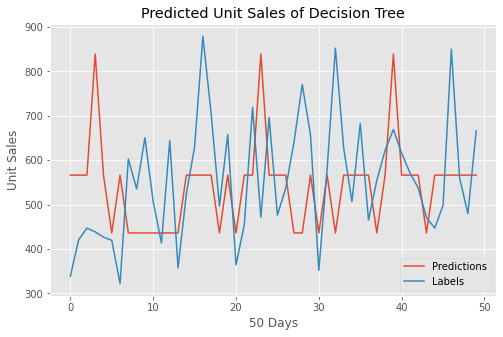

In [63]:
# setting variable names
num_days_plot = 50

# plot settings
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
plt.xlabel(str(num_days_plot) + ' Days')
plt.ylabel('Unit Sales')
plt.title('Predicted Unit Sales of Decision Tree')

# plotting the arrays
plt.plot(dt_val_preds[:num_days_plot], label='Predictions')
plt.plot(val_labels[:num_days_plot], label='Labels')
plt.legend()
plt.show()

#### Running on All Items

In [64]:
# defining a custom scorer for optimization

from sklearn.metrics import make_scorer
def mape_scorer(y_true, y_pred):
  return mape_func(y_pred, y_true)

# creating a new instance of a scorer
mape_scorer = make_scorer(mape_scorer, greater_is_better=False)

In [ ]:
# importing grid search
from sklearn.model_selection import GridSearchCV

# setting variable names to get data
type_inp = 'A'
store_inp = 49
num_past_inp = 25
days_in_future_inp = 7

# creating a dictionary to store data
dt_dict = {'item_nbr': [], 'dt_test_mape': [], 'dt_test_rmsle': []}

# looping through all items
for item in tqdm(test_items):

  # getting the data
  X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item, days_in_future_inp, num_past_inp)

  if X_train.size != 0:

    # CREATING GRID

    # max_depth of tree
    max_depth = [int(x) for x in np.linspace(1, 20, num = 20)]
    max_depth.append(None)
    # min_samples_split possibilities
    min_samples_split = [2, 5, 10, 15, 20, 25, 30]
    # Create the hyperparameter grid
    dt_grid = {'max_depth': max_depth,
              'min_samples_split': min_samples_split
              }
    
    # GRID SEARCH

    # First create the base model to tune
    dt = DecisionTreeRegressor()

    # Grid search of parameters, using 10 fold cross validation, search across 100 different combinations, and use all available cores
    dt_best = GridSearchCV(estimator=dt, param_grid=dt_grid, scoring=mape_scorer, cv=10, verbose=0, n_jobs=-1)

    # Fit the model
    dt_y_train = np.reshape(y_train, (y_train.shape[0]))
    dt_best.fit(X_train, y_train)

    # making predictions
    dt_train_preds = dt_best.predict(X_train)
    dt_test_preds = dt_best.predict(X_test)

    # reshaping
    train_labels = np.reshape(y_train, (y_train.shape[0]))
    test_labels = np.reshape(y_test, (y_test.shape[0]))
    rmsle_train_preds = np.reshape(dt_train_preds, (dt_train_preds.shape[0], 1))
    rmsle_test_preds = np.reshape(dt_test_preds, (dt_test_preds.shape[0], 1))

    # calculating error metrics
    dt_train_mape = mape_func(dt_train_preds, train_labels)
    dt_test_mape = mape_func(dt_test_preds, test_labels)
    dt_train_rmsle = rmsle(train_labels, rmsle_train_preds)
    dt_test_rmsle = rmsle(test_labels, rmsle_test_preds)

    # adding to dictionary
    dt_dict['item_nbr'].append(item)
    dt_dict['dt_test_mape'].append(dt_test_mape)
    dt_dict['dt_test_rmsle'].append(dt_test_rmsle)

# making a dataframe
dt_df = pd.DataFrame(dt_dict)

dt_df.head()

100%|██████████| 95/95 [53:38<00:00, 33.88s/it]


,item_nbr,dt_test_mape,dt_test_rmsle
0,1333307,24.971493,0.393912
1,502331,25.169007,0.275515
2,1309246,27.747450,0.351052
3,1998005,16.520559,0.235941
4,1309245,106.508693,0.793462


In [ ]:
print('Mean train MAPE: ' + str(round(np.mean(np.array(dt_df['dt_train_mape'])), 2)) + '%')
print('Mean val MAPE: ' + str(round(np.mean(np.array(dt_df['dt_val_mape'])), 2)) + '%')
print()
print('Mean train RMSLE: ' + str(round(np.mean(np.array(dt_df['dt_train_rmsle'])), 2)))
print('Mean val RMSLE: ' + str(round(np.mean(np.array(dt_df['dt_val_rmsle'])), 2)))

Mean train MAPE: 76.69%
Mean val MAPE: 53.44%

Mean train RMSLE: 0.61
Mean val RMSLE: 0.53


In [ ]:
# Now, I will save this df to a csv in google drive

dt_df.to_csv('dt_results.csv')
!cp dt_results.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results/Testing Results"

#### Combining Linreg and DT

Do this to compare results.

In [ ]:
linreg_dt_df = pd.merge(linreg_df, dt_df, on='item_nbr')

linreg_dt_df.head()

,item_nbr,linreg_train_mape,linreg_train_rmsle,linreg_val_mape,linreg_val_rmsle,dt_train_mape,dt_val_mape,dt_train_rmsle,dt_val_rmsle
0,1333307,52.583374,0.516804,22.972528,0.283155,90.839694,25.989423,0.727196,0.419208
1,502331,28.634624,0.325896,22.567780,0.261024,32.019635,31.597488,0.360388,0.323093
2,1309246,41.429287,0.423720,27.041649,0.309537,56.954002,24.769253,0.530198,0.322671
3,1998005,48.102828,0.435544,21.114922,0.245381,102.309392,21.081374,0.713287,0.286125
4,1309245,116.079735,0.789549,53.198005,0.559631,82.739704,60.828383,0.640079,0.652263


In [ ]:
# Now, I will save this df to a csv in google drive

linreg_dt_df.to_csv('linreg_dt_results.csv')
!cp linreg_dt_results.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results"

In [ ]:
print('mean dt:', np.mean(np.array(linreg_dt_df['dt_val_mape'])))
print('mean linreg:', np.mean(np.array(linreg_dt_df['linreg_val_mape'])))

mean dt: 53.442843331679974
mean linreg: 45.16813765072474


### XGBoost

#### Running on One Item

First, we need to get the predictions.

In [65]:
# now, let's create a custom scorer using the MAPE

from sklearn.metrics import make_scorer
def mape_scorer(y_true, y_pred):
  return mape_func(y_pred, y_true)

# creating a new instance of a scorer
scorer = make_scorer(mape_scorer, greater_is_better=False)

In [66]:
# setting variable names to get data
type_inp = 'A'
store_inp = 49
item_inp = 1926217
num_past_inp = 25
days_in_future_inp = 7

from sklearn.model_selection import GridSearchCV
from xgboost import xgb

# getting data
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_inp, store_inp, item_inp, days_in_future_inp, num_past_inp)

# making sure we have enough data
if X_train.size != 0:

  # controlling the number of trees
  n_estimators = [int(x) for x in np.linspace(1, 50, num=10)]

  # controlling max_depth of each tree
  max_depth = [int(x) for x in np.linspace(2, 30, num=15)]

  # controlling learning rate
  learning_rate = [x-1 for x in np.logspace(0.01, 0.3, num=10)]

  # creating the grid
  xgb_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'learning_rate': learning_rate
              }

  # GRID SEARCH

  # creating the base model
  xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

  # Grid search of parameters, using 4 fold cross validation, use all available cores
  grid = GridSearchCV(xgb_model, xgb_grid, verbose=1, scoring=scorer, cv = 3, n_jobs = -1)

  # fitting the model
  grid.fit(X_train, y_train)

  # getting the best estimator and making predictions
  xgb_y_train = np.reshape(y_train, (y_train.shape[0]))
  grid.best_estimator_.fit(X_train, xgb_y_train)

  train_preds = grid.best_estimator_.predict(X_train)
  val_preds = grid.best_estimator_.predict(X_val)

  # reshaping
  train_labels = np.reshape(y_train, (y_train.shape[0]))
  val_labels = np.reshape(y_val, (y_val.shape[0]))
  rmsle_train_preds = np.reshape(train_preds, (train_preds.shape[0], 1))
  rmsle_val_preds = np.reshape(val_preds, (val_preds.shape[0], 1))

else:
  print('Not enough data.')

First, we need to figure out our error metrics.

In [ ]:
xgb_grid

In [ ]:
# calculating error metrics
train_mape = mape_func(train_preds, train_labels)
val_mape = mape_func(val_preds, val_labels)
train_rmsle = rmsle(y_train, rmsle_train_preds)
val_rmsle = rmsle(y_val, rmsle_val_preds)

# printing MAPE and RMSLE
print('The val MAPE was: '+ str(round(val_mape, 2)) + '%')
print('The val RMSLE was: '+ str(round(val_rmsle, 2)))

Then, we can print out the optimized model to take a look at the parameters.

In [ ]:
grid.best_estimator_

Now, we can plot the predictions against the labels.

In [ ]:
# setting variable names
num_days_plot = 50

# plot settings
plt.figure(figsize=(8, 5))
plt.style.use('ggplot')
plt.xlabel(str(num_days_plot) + ' Days')
plt.ylabel('Unit Sales')
plt.title('Predicted Unit Sales of Decision Tree')

# plotting the arrays
plt.plot(dt_val_preds[:num_days_plot], label='Predictions')
plt.plot(val_labels[:num_days_plot], label='Labels')
plt.legend()
plt.show()

#### Running on All Items

In [ ]:
# setting variables for parameters
item_input_nbr = 1503844
type_input_nbr = 'A'
days_in_future_input = 7
num_past_input = 25
ewma_num_past_input = 15
store_nbr_input = 49

# getting all preds and mse
X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_input_nbr, store_nbr_input, item_input_nbr, days_in_future_input, num_past_input)

In [ ]:
from sklearn.model_selection import GridSearchCV

# controlling the number of trees
n_estimators = [int(x) for x in np.linspace(1, 50, num=12)]

# controlling max_depth of each tree
max_depth = [int(x) for x in np.linspace(2, 30, num=15)]

# controlling learning rate
learning_rate = [x-1 for x in np.logspace(0.01, 0.3, num=10)]

# creating the grid
xgb_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate
            }

In [ ]:
# creating a custom scorer

from sklearn.metrics import make_scorer

def mape_scorer(y_true, y_pred):
  return mape_func(y_pred, y_true)

scorer = make_scorer(mape_scorer, greater_is_better=False)

In [ ]:
# creating the base model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Grid search of parameters, using 3 fold cross validation, use all available cores
grid = GridSearchCV(xgb_model, xgb_grid, verbose=1, scoring=scorer, cv = 3, n_jobs = -1)

# altering y_train & fitting the model
xgb_y_train = np.reshape(y_train, (y_train.shape[0]))
grid.fit(X_train, xgb_y_train)

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 546 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 1004 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1558 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2224 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3082 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4060 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 5118 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:  8.8min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=...
                                           0.37685716485275833,
                                           0.48289742522992474,
                                           0.5971044999346031,
                                           0.7201073656971679,
                                           0.8525834406244575,
         

In [ ]:
xgb_y_train = np.reshape(y_train, (y_train.shape[0]))
grid.best_estimator_.fit(X_train, xgb_y_train)
preds = grid.best_estimator_.predict(X_val)

print(mape_func(preds, y_val))

23.397327900669897


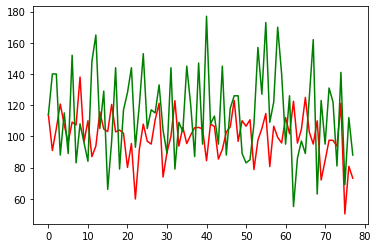

In [ ]:
plt.plot(preds[-100:], color='red')
plt.plot(y_val[-100:], color='green')

Comparing to linear regression.

In [ ]:
linreg_preds, linreg_mse, linreg_mae, linreg_mape, linreg_labels = linreg_model(X_train, X_val, y_train, y_val)
print(linreg_mape)

22.42151660558681


Comparing to unoptimized XGBoost.

In [ ]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
no_opt_preds = xgb_model.predict(X_val)

print(mape_func(no_opt_preds, y_val))

24.30198787433596


Running on all items.

In [69]:
from sklearn.model_selection import GridSearchCV

# setting variables for parameters
type_input_nbr = 'A'
days_in_future_input = 1
num_past_input = 25
ewma_num_past_input = 15
store_nbr_input = 49

# dict
xgb_opt_dict = {'item_nbr': [], 'xgb_mape': [], 'xgb_rmsle': [], 'xgb_mae': []}

# items list
items = test_items

for item in tqdm(items[27:50]):
  
  # getting all data
  X_train, X_val, X_test, y_train, y_val, y_test, ml_train, ml_val, ml_test = preprocess(type_input_nbr, store_nbr_input, item, days_in_future_input, num_past_input)

  if X_train.size != 0:

    # controlling the number of trees
    n_estimators = [int(x) for x in np.linspace(2, 30, num=15)]

    # controlling max_depth of each tree
    max_depth = [int(x) for x in np.linspace(2, 30, num=15)]
    max_depth.append(6)

    # controlling learning rate
    learning_rate = [x-1 for x in np.logspace(0.01, 0.3, num=10)]     # CHANGE COMPARED TO LAST WEEK - LINSPACE CHANGED TO LOGSPACE
    learning_rate.append(0.3)

    # creating the grid
    xgb_grid = {'n_estimators': n_estimators,
                'max_depth': max_depth,
                'learning_rate': learning_rate
                }
    
    # creating the base model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', nthread=-1, njobs=-1)

    # Grid search of parameters, using 3 fold cross validation, use all available cores
    grid = GridSearchCV(xgb_model, xgb_grid, verbose=2, scoring=scorer, cv = 3, n_jobs = -1)

    # altering y_train & fitting the model
    xgb_y_train = np.reshape(y_train, (y_train.shape[0]))
    grid.fit(X_train, xgb_y_train)

    # getting preds
    grid.best_estimator_.fit(X_train, xgb_y_train)
    xgb_preds = grid.best_estimator_.predict(X_test)

    # removing the bad data
    if item == 1503844:
      for i in range(len(y_test)):
        if y_test[i][0] < 1:
          xgb_preds = np.delete(xgb_preds, i, 0)
          y_test = np.delete(y_test, i, 0)
          break

    # creating 1d and 2d preds and labels
    one_d_xgb_preds = np.reshape(xgb_preds, (xgb_preds.shape[0]))
    one_d_xgb_labels = np.reshape(y_test, (y_test.shape[0]))
    two_d_xgb_preds = np.reshape(xgb_preds, (xgb_preds.shape[0], 1))
    two_d_xgb_labels = np.reshape(y_test, (y_test.shape[0], 1))

    # get error metrics
    xgb_mape = mape_func(one_d_xgb_preds, one_d_xgb_labels)
    xgb_rmsle = rmsle(two_d_xgb_labels, two_d_xgb_preds)
    xgb_mae = mean_absolute_error(one_d_xgb_labels, one_d_xgb_preds)

    # append to dictionary
    xgb_opt_dict['item_nbr'].append(item)
    xgb_opt_dict['xgb_mape'].append(xgb_mape)
    xgb_opt_dict['xgb_rmsle'].append(xgb_rmsle)
    xgb_opt_dict['xgb_mae'].append(xgb_mae)

xgb_opt_df = pd.DataFrame(xgb_opt_dict)

xgb_opt_df.head()

In [69]:
# Now, I will save this df to a csv in google drive

xgb_opt_df.to_csv('xgb_results_27_to_50.csv')
!cp xgb_results_27_to_50.csv "drive/My Drive/High School/Science Fair 2020/Machine Learning/Nitya Mentorship/Notebook Versions/Results/Model Results/Testing Results - 1 Day"

#### Building One XGBoost model for **all items** - BEST RESULTS

In [ ]:
"""
Notes

- one XGBoost for 95 items, store 49
- data format:
    [t-25 sales, t-24 sales, ... , t sales, one-hot encoding of 95 items]
- how to get data:
  - get clear dates for train, val, and test
  - get 25-vectors and add one-hot encoding for all three
  - combine arrays for all items

"""

##### Creating `get_data_items`, function needed to get the sales data for each item family.

In [70]:
def get_data_items(test_items, item_family):

  return_items = []

  for item in test_items:
    temp_item_family = np.array(items_df.loc[items_df['item_nbr'] == item, 'family'])[0]
    if temp_item_family == item_family:
      return_items.append(item)
  
  return return_items

##### Actually getting all the data.

In [71]:
# defining what store to get data from
days_in_future_input = 1
num_past = 25
type_input_nbr = 'A'

# creating a list of item families and stores
families = np.unique(np.array(items_df.loc[items_df['perishable'] == 1, 'family']))
families_num = np.arange(1, len(families) + 1)
families_dict = dict(zip(families, families_num))
stores = np.unique(np.array(stores_df.loc[stores_df['type'] == 'A', 'store_nbr']))

# stores = [1, 2, 3, 4]

X_train_complete, X_val_complete, X_test_complete, y_train_complete, y_val_complete, y_test_complete = [], [], [], [], [], []

for h in range(len(stores)):

  store = stores[h]

  # narrowing down df and getting dates
  temp_df = train[train['store_nbr'] == store]
  dates = np.array(temp_df['date'].unique())

  # defining separate train, test, and val dates
  train_len = int(len(dates) * 0.7)
  val_len = int(len(dates) * 0.15)
  test_len = int(len(dates) * 0.15)

  # getting date restrictions
  train_dates = dates[:train_len]
  val_dates = dates[train_len:train_len + val_len]
  test_dates = dates[train_len + val_len:]

  # keeping track of usable items
  usable_items = []

  # looping through all items
  for item in test_items:
    
    # narrowing down df
    temp_item_df = temp_df[temp_df['item_nbr'] == item]

    # creating train df
    temp_train_df = temp_item_df[temp_item_df['date'] <= train_dates[-1]]
    temp_train_df = temp_train_df.groupby(['date']).sum()

    # creating val df
    temp_val_df = temp_item_df[temp_item_df['date'] >= val_dates[1]]
    temp_val_df = temp_val_df[temp_val_df['date'] <= val_dates[-1]]
    temp_val_df = temp_val_df.groupby(['date']).sum()

    # creating test df
    temp_test_df = temp_item_df[temp_item_df['date'] >= test_dates[1]]
    temp_test_df = temp_test_df.groupby(['date']).sum()

    # checking to see if the item has enough data
    if len(temp_train_df) > num_past + days_in_future_input and len(temp_val_df) > num_past + days_in_future_input and len(temp_test_df) > num_past + days_in_future_input:

      # appending to usable_items arr
      usable_items.append(item)
    
  # creating full arrays
  X_train_full, X_val_full, X_test_full, y_train_full, y_val_full, y_test_full = [], [], [], [], [], []

  for i in range(len(usable_items)):

    # getting the current item
    item = usable_items[i]

    # narrowing down df
    temp_item_df = temp_df[temp_df['item_nbr'] == item]

    # creating train df
    temp_train_df = temp_item_df[temp_item_df['date'] <= train_dates[-1]]
    temp_train_df = temp_train_df.groupby(['date']).sum()

    # creating val df
    temp_val_df = temp_item_df[temp_item_df['date'] >= val_dates[1]]
    temp_val_df = temp_val_df[temp_val_df['date'] <= val_dates[-1]]
    temp_val_df = temp_val_df.groupby(['date']).sum()

    # creating test df
    temp_test_df = temp_item_df[temp_item_df['date'] >= test_dates[1]]
    temp_test_df = temp_test_df.groupby(['date']).sum()

    # checking to see if the item has enough data
    if len(temp_train_df) > num_past + days_in_future_input and len(temp_val_df) > num_past + days_in_future_input and len(temp_test_df) > num_past + days_in_future_input:

      # getting train sales
      X_train_arr = np.array(temp_train_df['unit_sales'])[:-days_in_future_input]
      y_train_arr = np.array(temp_train_df['unit_sales'])[days_in_future_input:]

      # reshaping train sales
      X_train_arr = np.reshape(X_train_arr, (X_train_arr.shape[0], 1))
      y_train_arr = np.reshape(y_train_arr, (y_train_arr.shape[0], 1))

      # getting train feature vectors
      X_train, y_train = construct_predictor_vectors(X_train_arr, y_train_arr, num_past)

      # getting val sales
      X_val_arr = np.array(temp_val_df['unit_sales'])[:-days_in_future_input]
      y_val_arr = np.array(temp_val_df['unit_sales'])[days_in_future_input:]

      # reshaping val sales
      X_val_arr = np.reshape(X_val_arr, (X_val_arr.shape[0], 1))
      y_val_arr = np.reshape(y_val_arr, (y_val_arr.shape[0], 1))

      # getting val feature vectors
      X_val, y_val = construct_predictor_vectors(X_val_arr, y_val_arr, num_past)

      # getting test sales
      X_test_arr = np.array(temp_test_df['unit_sales'])[:-days_in_future_input]
      y_test_arr = np.array(temp_test_df['unit_sales'])[days_in_future_input:]

      # reshaping test sales
      X_test_arr = np.reshape(X_test_arr, (X_test_arr.shape[0], 1))
      y_test_arr = np.reshape(y_test_arr, (y_test_arr.shape[0], 1))
    
      # getting test feature vectors
      X_test, y_test = construct_predictor_vectors(X_test_arr, y_test_arr, num_past)

      # creating the one-hot encoding
      # one_hot_arr = np.zeros(len(usable_items))
      # one_hot_arr[i] = 1

      # creating the new arrays to fit the one-hot
      num_extra_features = 3
      new_X_train = np.zeros((X_train.shape[0], X_train.shape[1] + num_extra_features))
      new_X_val = np.zeros((X_val.shape[0], X_val.shape[1] + num_extra_features))
      new_X_test = np.zeros((X_test.shape[0], X_test.shape[1] + num_extra_features))

      # adding category as a feature
      temp_family_num = families_dict[np.array(items_df.loc[items_df['item_nbr'] == item, 'family'])[0]]
      
      # adding the one-hot encoding - with store as a feature
      for j in range(len(X_train)):
        new_X_train[j] = list(X_train[j]) + [item] + [temp_family_num] + [store]
      for j in range(len(X_val)):
        new_X_val[j] = list(X_val[j]) + [item] + [temp_family_num] + [store]
      for j in range(len(X_test)):
        new_X_test[j] = list(X_test[j]) + [item] + [temp_family_num] + [store]

      X_train = new_X_train
      X_val = new_X_val
      X_test = new_X_test

      if i == 0:
        X_train_full = X_train.copy()
        X_val_full = X_val.copy()
        X_test_full = X_test.copy()
        y_train_full = y_train.copy()
        y_val_full = y_val.copy()
        y_test_full = y_test.copy()
      else:
        X_train_full = np.concatenate((X_train_full, X_train), axis=0)
        y_train_full = np.concatenate((y_train_full, y_train), axis=0)
        X_val_full = np.concatenate((X_val_full, X_val), axis=0)
        y_val_full = np.concatenate((y_val_full, y_val), axis=0)
        X_test_full = np.concatenate((X_test_full, X_test), axis=0)
        y_test_full = np.concatenate((y_test_full, y_test), axis=0)

  if h == 0:
    X_train_complete = X_train_full.copy()
    X_val_complete = X_val_full.copy()
    X_test_complete = X_test_full.copy()
    y_train_complete = y_train_full.copy()
    y_val_complete = y_val_full.copy()
    y_test_complete = y_test_full.copy()
  else:
    if len(X_train_full) != 0:
      X_train_complete = np.concatenate((X_train_complete, X_train_full), axis=0)
      y_train_complete = np.concatenate((y_train_complete, y_train_full), axis=0)
      X_val_complete = np.concatenate((X_val_complete, X_val_full), axis=0)
      y_val_complete = np.concatenate((y_val_complete, y_val_full), axis=0)
      X_test_complete = np.concatenate((X_test_complete, X_test_full), axis=0)
      y_test_complete = np.concatenate((y_test_complete, y_test_full), axis=0)

##### Running the base model

In [75]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20, min_samples_split=15, max_depth=20)
# model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train_complete, y_train_complete)
preds = model.predict(X_val_complete)

preds = np.reshape(preds, (preds.shape[0], 1))

mape_func(preds, y_val_complete)

50.47915827806221

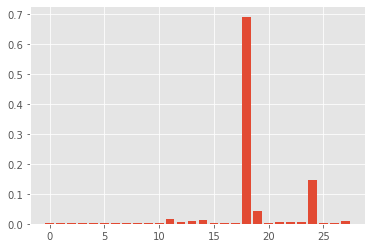

In [76]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [77]:
X_val_complete[0]

array([5.20000e+01, 5.90000e+01, 4.60000e+01, 3.40000e+01, 7.90000e+01,
       1.06000e+02, 6.60000e+01, 6.10000e+01, 4.70000e+01, 4.60000e+01,
       5.20000e+01, 1.02000e+02, 1.15000e+02, 6.00000e+01, 4.60000e+01,
       5.40000e+01, 2.60000e+01, 7.80000e+01, 9.30000e+01, 6.50000e+01,
       6.70000e+01, 7.70000e+01, 7.60000e+01, 1.21000e+02, 1.87000e+02,
       5.02331e+05, 1.00000e+00, 4.40000e+01])

##### Finding best parameters with Grid Search

In [ ]:
# now, let's create a custom scorer using the RMSLE

from sklearn.metrics import make_scorer
def rmsle_scorer(y_true, y_pred):
  return rmsle(y_true, y_pred)

# creating a new instance of a scorer
rmsle_scorer_instance = make_scorer(rmsle_scorer, greater_is_better=False)

In [ ]:
# now, let's create a custom scorer using the MAPE

from sklearn.metrics import make_scorer
def mape_scorer(y_true, y_pred):
  return mape_func(y_pred, y_true)

# creating a new instance of a scorer
scorer = make_scorer(mape_scorer, greater_is_better=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

# running a grid search
# controlling three parameters: n_estimators, max_depth, min_samples_split

# controlling the number of trees
# n_estimators = [int(x) for x in np.linspace(1, 100, num=15)]
n_estimators = [int(x) for x in np.linspace(15, 20, num=1)]

# controlling max_depth of each tree
# max_depth = [int(x) for x in np.linspace(2, 30, num=15)]
max_depth = [int(x) for x in np.linspace(15, 20, num=1)]

# controlling learning rate
learning_rate = [x-1 for x in np.logspace(0.01, 0.1, num=10)]

# creating the grid
xgb_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate
            }

# GRID SEARCH

# creating the base model
xgb_base_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Grid search of parameters, using 4 fold cross validation, use all available cores
xgb_grid = GridSearchCV(xgb_base_model, xgb_grid, verbose=2, scoring='neg_mean_squared_error', cv=2)

# reshaping X_train
X_train_grid_search = np.reshape(X_train_complete, (X_train_complete.shape[0], X_train_complete.shape[1], 1))

# fitting the model
xgb_grid.fit(X_train_complete, y_train_complete)

# making predictions
xgb_grid_val_preds = xgb_grid.best_estimator_.predict(X_val_complete)

# reshaping predictions
xgb_grid_val_preds = np.reshape(xgb_grid_val_preds, (xgb_grid_val_preds.shape[0]))
xgb_grid_val_labels = np.reshape(y_val_complete, (y_val_complete.shape[0]))

mape_func(xgb_grid_val_preds, xgb_grid_val_labels)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] learning_rate=0.0232929922807541, max_depth=15, n_estimators=15 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.0232929922807541, max_depth=15, n_estimators=15, total=  15.3s
[CV] learning_rate=0.0232929922807541, max_depth=15, n_estimators=15 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.3s remaining:    0.0s


[CV]  learning_rate=0.0232929922807541, max_depth=15, n_estimators=15, total=  15.1s
[CV] learning_rate=0.04712854805089961, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.04712854805089961, max_depth=15, n_estimators=15, total=  15.3s
[CV] learning_rate=0.04712854805089961, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.04712854805089961, max_depth=15, n_estimators=15, total=  15.3s
[CV] learning_rate=0.07151930523760641, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.07151930523760641, max_depth=15, n_estimators=15, total=  15.4s
[CV] learning_rate=0.07151930523760641, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.07151930523760641, max_depth=15, n_estimators=15, total=  19.6s
[CV] learning_rate=0.09647819614318509, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.09647819614318509, max_depth=15, n_estimators=15, total=  15.2s
[CV] learning_rate=0.09647819614318509, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.09647819614318509, max_depth=15, n_es

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.2min finished


54.83835402023856

##### Running the whole thing together

In [72]:
# defining what store to get data from
days_in_future_input = 1
num_past = 25
type_input_nbr = 'A'

# creating a list of item families and stores
families = np.unique(np.array(items_df.loc[items_df['perishable'] == 1, 'family']))
families_num = np.arange(1, len(families) + 1)
families_dict = dict(zip(families, families_num))
stores = np.unique(np.array(stores_df.loc[stores_df['type'] == 'A', 'store_nbr']))
# stores = [1, 2, 3, 4]

X_train_complete, X_val_complete, X_test_complete, y_train_complete, y_val_complete, y_test_complete = [], [], [], [], [], []

for h in range(len(stores)):

  store = stores[h]

  # narrowing down df and getting dates
  temp_df = train[train['store_nbr'] == store]
  dates = np.array(temp_df['date'].unique())

  # defining separate train, test, and val dates
  train_len = int(len(dates) * 0.7)
  val_len = int(len(dates) * 0.15)
  test_len = int(len(dates) * 0.15)

  # getting date restrictions
  train_dates = dates[:train_len]
  val_dates = dates[train_len:train_len + val_len]
  test_dates = dates[train_len + val_len:]

  # keeping track of usable items
  usable_items = []

  # looping through all items
  for item in test_items:
    
    # narrowing down df
    temp_item_df = temp_df[temp_df['item_nbr'] == item]

    # creating train df
    temp_train_df = temp_item_df[temp_item_df['date'] <= train_dates[-1]]
    temp_train_df = temp_train_df.groupby(['date']).sum()

    # creating val df
    temp_val_df = temp_item_df[temp_item_df['date'] >= val_dates[1]]
    temp_val_df = temp_val_df[temp_val_df['date'] <= val_dates[-1]]
    temp_val_df = temp_val_df.groupby(['date']).sum()

    # creating test df
    temp_test_df = temp_item_df[temp_item_df['date'] >= test_dates[1]]
    temp_test_df = temp_test_df.groupby(['date']).sum()

    # checking to see if the item has enough data
    if len(temp_train_df) > num_past + days_in_future_input and len(temp_val_df) > num_past + days_in_future_input and len(temp_test_df) > num_past + days_in_future_input:

      # appending to usable_items arr
      usable_items.append(item)
    
  # creating full arrays
  X_train_full, X_val_full, X_test_full, y_train_full, y_val_full, y_test_full = [], [], [], [], [], []

  for i in range(len(usable_items)):

    # getting the current item
    item = usable_items[i]

    # narrowing down df
    temp_item_df = temp_df[temp_df['item_nbr'] == item]

    # creating train df
    temp_train_df = temp_item_df[temp_item_df['date'] <= train_dates[-1]]
    temp_train_df = temp_train_df.groupby(['date']).sum()

    # creating val df
    temp_val_df = temp_item_df[temp_item_df['date'] >= val_dates[1]]
    temp_val_df = temp_val_df[temp_val_df['date'] <= val_dates[-1]]
    temp_val_df = temp_val_df.groupby(['date']).sum()

    # creating test df
    temp_test_df = temp_item_df[temp_item_df['date'] >= test_dates[1]]
    temp_test_df = temp_test_df.groupby(['date']).sum()

    # checking to see if the item has enough data
    if len(temp_train_df) > num_past + days_in_future_input and len(temp_val_df) > num_past + days_in_future_input and len(temp_test_df) > num_past + days_in_future_input:

      # getting train sales
      X_train_arr = np.array(temp_train_df['unit_sales'])[:-days_in_future_input]
      y_train_arr = np.array(temp_train_df['unit_sales'])[days_in_future_input:]

      # reshaping train sales
      X_train_arr = np.reshape(X_train_arr, (X_train_arr.shape[0], 1))
      y_train_arr = np.reshape(y_train_arr, (y_train_arr.shape[0], 1))

      # getting train feature vectors
      X_train, y_train = construct_predictor_vectors(X_train_arr, y_train_arr, num_past)

      # getting val sales
      X_val_arr = np.array(temp_val_df['unit_sales'])[:-days_in_future_input]
      y_val_arr = np.array(temp_val_df['unit_sales'])[days_in_future_input:]

      # reshaping val sales
      X_val_arr = np.reshape(X_val_arr, (X_val_arr.shape[0], 1))
      y_val_arr = np.reshape(y_val_arr, (y_val_arr.shape[0], 1))

      # getting val feature vectors
      X_val, y_val = construct_predictor_vectors(X_val_arr, y_val_arr, num_past)

      # getting test sales
      X_test_arr = np.array(temp_test_df['unit_sales'])[:-days_in_future_input]
      y_test_arr = np.array(temp_test_df['unit_sales'])[days_in_future_input:]

      # reshaping test sales
      X_test_arr = np.reshape(X_test_arr, (X_test_arr.shape[0], 1))
      y_test_arr = np.reshape(y_test_arr, (y_test_arr.shape[0], 1))
    
      # getting test feature vectors
      X_test, y_test = construct_predictor_vectors(X_test_arr, y_test_arr, num_past)

      # creating the one-hot encoding
      # one_hot_arr = np.zeros(len(usable_items))
      # one_hot_arr[i] = 1

      # creating the new arrays to fit the one-hot
      num_extra_features = 3
      new_X_train = np.zeros((X_train.shape[0], X_train.shape[1] + num_extra_features))
      new_X_val = np.zeros((X_val.shape[0], X_val.shape[1] + num_extra_features))
      new_X_test = np.zeros((X_test.shape[0], X_test.shape[1] + num_extra_features))

      # adding category as a feature
      temp_family_num = families_dict[np.array(items_df.loc[items_df['item_nbr'] == item, 'family'])[0]]
      
      # adding the one-hot encoding - with store as a feature
      for j in range(len(X_train)):
        new_X_train[j] = list(X_train[j]) + [item] + [temp_family_num] + [store]
      for j in range(len(X_val)):
        new_X_val[j] = list(X_val[j]) + [item] + [temp_family_num] + [store]
      for j in range(len(X_test)):
        new_X_test[j] = list(X_test[j]) + [item] + [temp_family_num] + [store]

      X_train = new_X_train
      X_val = new_X_val
      X_test = new_X_test

      if i == 0:
        X_train_full = X_train.copy()
        X_val_full = X_val.copy()
        X_test_full = X_test.copy()
        y_train_full = y_train.copy()
        y_val_full = y_val.copy()
        y_test_full = y_test.copy()
      else:
        X_train_full = np.concatenate((X_train_full, X_train), axis=0)
        y_train_full = np.concatenate((y_train_full, y_train), axis=0)
        X_val_full = np.concatenate((X_val_full, X_val), axis=0)
        y_val_full = np.concatenate((y_val_full, y_val), axis=0)
        X_test_full = np.concatenate((X_test_full, X_test), axis=0)
        y_test_full = np.concatenate((y_test_full, y_test), axis=0)

  if h == 0:
    X_train_complete = X_train_full.copy()
    X_val_complete = X_val_full.copy()
    X_test_complete = X_test_full.copy()
    y_train_complete = y_train_full.copy()
    y_val_complete = y_val_full.copy()
    y_test_complete = y_test_full.copy()
  else:
    if len(X_train_full) != 0:
      X_train_complete = np.concatenate((X_train_complete, X_train_full), axis=0)
      y_train_complete = np.concatenate((y_train_complete, y_train_full), axis=0)
      X_val_complete = np.concatenate((X_val_complete, X_val_full), axis=0)
      y_val_complete = np.concatenate((y_val_complete, y_val_full), axis=0)
      X_test_complete = np.concatenate((X_test_complete, X_test_full), axis=0)
      y_test_complete = np.concatenate((y_test_complete, y_test_full), axis=0)

import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=30, min_samples_split=15, max_depth=20)
model.fit(X_train_complete, y_train_complete)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, min_samples_split=15,
             missing=None, n_estimators=30, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

MAPE: 20.759632193058795
RMSLE: 0.24934798239599554


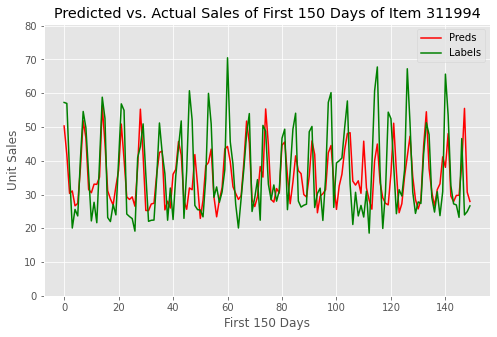

In [73]:
preds = model.predict(X_test_complete)

preds = np.reshape(preds, (preds.shape[0], 1))

temp_item_index_list = []

# chosen_item = 502331
chosen_item = 311994
chosen_store = 47

for i in range(len(X_test_complete)):
  if X_test_complete[i][25] == chosen_item and X_val_complete[i][27] == chosen_store:
    if y_test_complete[i][0] >= 1:
      temp_item_index_list.append(i)

X_test_temp_item = X_test_complete[temp_item_index_list]
y_test_temp_item = y_test_complete[temp_item_index_list]
preds_temp_item = preds[temp_item_index_list]

y_test_temp_item_rmsle = np.reshape(y_test_temp_item, (y_test_temp_item.shape[0], 1))
preds_temp_item_rmsle = np.reshape(preds_temp_item, (preds_temp_item.shape[0], 1))

print('MAPE:', mape_func(preds_temp_item, y_test_temp_item))
print('RMSLE:', rmsle(y_test_temp_item_rmsle, preds_temp_item_rmsle))

plt.figure(figsize=(8, 5))

plt.plot(preds_temp_item[:150], color='red', label='Preds')
plt.plot(y_test_temp_item[:150], color='green', label='Labels')

plt.xlabel('First 150 Days')
plt.ylabel('Unit Sales')
plt.title('Predicted vs. Actual Sales of First 150 Days of Item ' + str(chosen_item))
plt.legend()
plt.ylim(0, max(max(preds_temp_item), max(y_test_temp_item)) + 10)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Number of Days on which x number of items was sold')

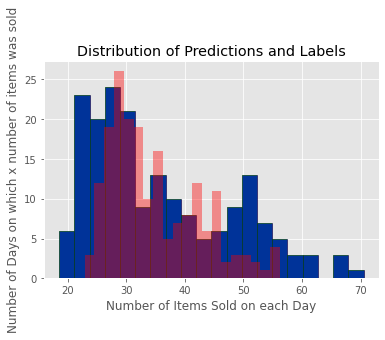

In [74]:
# Distribution of Labels and Predictions


plt.hist(y_test_temp_item, color = 'blue', edgecolor = 'black',
         bins = 20)

# seaborn histogram
sns.distplot(y_test_temp_item, hist=True, kde=False, 
             bins=20, color = 'green')
sns.distplot(preds_temp_item, hist=True, kde=False, 
             bins=20, color = 'red')

plt.title('Distribution of Predictions and Labels')
plt.xlabel('Number of Items Sold on each Day')
plt.ylabel('Number of Days on which x number of items was sold')

##### What is the MAPE of the big XGBoost for predicting the highest-selling item?

First, making predictions on testing data.

In [78]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20, min_samples_split=10, max_depth=15)
#model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train_complete, y_train_complete)
preds = model.predict(X_test_complete)

preds = np.reshape(preds, (preds.shape[0], 1))

mape_func(preds, y_test_complete)

51.23272250854986

In [79]:
# finding MAPEs of all items in store 49

item_list_evaluate = test_items

item_mapes_evaluate = {}

for item in item_list_evaluate:

  temp_item_index_list = []

  for i in range(len(X_test_complete)):
    # if X_val_complete[i][25] == item and X_val_complete[i][27] == 49:
    if X_test_complete[i][25] == item:
      temp_item_index_list.append(i)

  X_test_temp_item = X_test_complete[temp_item_index_list]
  y_test_temp_item = y_test_complete[temp_item_index_list]
  preds_temp_item = preds[temp_item_index_list]

  if X_test_temp_item.size != 0:
    item_mapes_evaluate[item] = mape_func(preds_temp_item, y_test_temp_item)

items_lowest_mape = sorted(item_mapes_evaluate, key=lambda x: item_mapes_evaluate[x])

items_lowest_mape[:10]

[502331,
 311994,
 1473474,
 1695845,
 1473482,
 1309246,
 582864,
 1686656,
 1083196,
 584028]

In [80]:
temp_item_index_list = []

for i in range(len(X_test_complete)):
  if X_test_complete[i][25] == 1503844 and X_val_complete[i][27] == 49:
    if y_test_complete[i][0] >= 1:
      temp_item_index_list.append(i)

X_test_temp_item = X_test_complete[temp_item_index_list]
y_test_temp_item = y_test_complete[temp_item_index_list]
preds_temp_item = preds[temp_item_index_list]

y_test_temp_item_rmsle = np.reshape(y_test_temp_item, (y_test_temp_item.shape[0], 1))
preds_temp_item_rmsle = np.reshape(preds_temp_item, (preds_temp_item.shape[0], 1))

print('MAPE:', mape_func(preds_temp_item, y_test_temp_item))
print('RMSLE:', rmsle(y_test_temp_item_rmsle, preds_temp_item_rmsle))

MAPE: 27.213529667981806
RMSLE: 0.3660541849555457


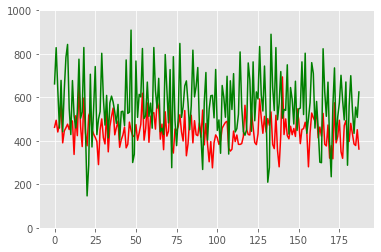

In [81]:
plt.plot(preds_temp_item, color='red')
plt.plot(y_test_temp_item, color='green')
plt.ylim(0, 1000)

plt.show()

Making predictions on validation data.

In [82]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, min_samples_split=15, max_depth=15)
# model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train_complete, y_train_complete)
preds = model.predict(X_val_complete)

preds = np.reshape(preds, (preds.shape[0], 1))

mape_func(preds, y_val_complete)

56.37753135050883

In [83]:
# finding MAPEs of all items in store 49

item_list_evaluate = test_items

item_mapes_evaluate = {}

for item in item_list_evaluate:

  temp_item_index_list = []

  for i in range(len(X_val_complete)):
    # if X_val_complete[i][25] == item and X_val_complete[i][27] == 49:
    if X_val_complete[i][25] == item and X_val_complete[i][27] == 49:
      temp_item_index_list.append(i)

  X_val_temp_item = X_val_complete[temp_item_index_list]
  y_val_temp_item = y_val_complete[temp_item_index_list]
  preds_temp_item = preds[temp_item_index_list]

  if X_val_temp_item.size != 0:
    item_mapes_evaluate[item] = mape_func(preds_temp_item, y_val_temp_item)

items_lowest_mape = sorted(item_mapes_evaluate, key=lambda x: item_mapes_evaluate[x])

items_lowest_mape[:10]

[1427659,
 1503844,
 1473474,
 557420,
 1584576,
 1695845,
 502331,
 1473393,
 1239897,
 699703]

In [84]:
temp_item_index_list = []

for i in range(len(X_val_complete)):
  if X_val_complete[i][25] == 311994 and X_val_complete[i][27] == 49:
  # if X_val_complete[i][25] == 1503844:
    temp_item_index_list.append(i)

X_val_temp_item = X_val_complete[temp_item_index_list]
y_val_temp_item = y_val_complete[temp_item_index_list]
preds_temp_item = preds[temp_item_index_list]

y_val_temp_item_rmsle = np.reshape(y_val_temp_item, (y_val_temp_item.shape[0], 1))
preds_temp_item_rmsle = np.reshape(preds_temp_item, (preds_temp_item.shape[0], 1))

print('MAPE:', mape_func(preds_temp_item, y_val_temp_item))
print('RMSLE:', rmsle(y_val_temp_item_rmsle, preds_temp_item_rmsle))

MAPE: 27.092027155297703
RMSLE: 0.32035297156691744


(0.0, 125.304)

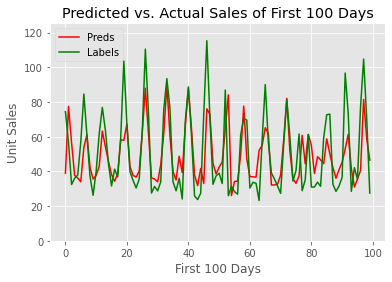

In [85]:
plt.plot(preds_temp_item[-100:], color='red', label='Preds')
plt.plot(y_val_temp_item[-100:], color='green', label='Labels')

plt.xlabel('First 100 Days')
plt.ylabel('Unit Sales')
plt.title('Predicted vs. Actual Sales of First 100 Days')
plt.legend()
plt.ylim(0, max(max(preds_temp_item), max(y_val_temp_item)) + 10)

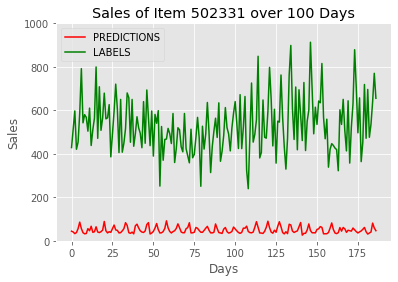

In [88]:
plt.plot(preds_temp_item[:200], color='red', label='PREDICTIONS')
plt.plot(y_val_temp_item[:200], color='green', label='LABELS')
plt.legend()
plt.ylim(0, 1000)

plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('Sales of Item 502331 over 100 Days')

plt.show()

##### Doing some Feature Importance Exploration for Further Optimization

##### What happens if I just include the following features: *t*-1, *t*-8, *t*-15, and *t*-23, along with item and category information?

In [89]:
kept_features_index_arr = [24-21, 24-17, 24-16, 24-15, 24-14, 24-7, 24, 25, 27]

X_train_feat_imp = X_train_complete[:, kept_features_index_arr]
X_val_feat_imp = X_val_complete[:, kept_features_index_arr]
X_test_feat_imp = X_test_complete[:, kept_features_index_arr]

import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=25, min_samples_split=15)
model.fit(X_train_feat_imp, y_train_complete)
preds = model.predict(X_val_feat_imp)

preds = np.reshape(preds, (preds.shape[0], 1))

print(mape_func(preds, y_val_complete))

70.3572585338379


In [90]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, min_samples_split=15,
             missing=None, n_estimators=25, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

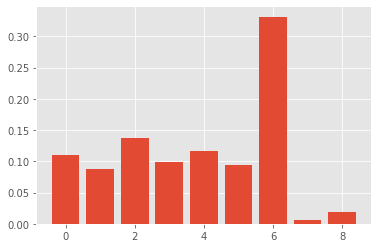

In [91]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [92]:
temp_item_index_list = []

for i in range(len(X_val_feat_imp)):
  # if X_val_complete[i][25] == 1503844 and X_val_complete[i][27] == 49:
  if X_val_feat_imp[i][X_val_feat_imp.shape[1] - 2] == 1503844:
    temp_item_index_list.append(i)

X_val_temp_item = X_val_feat_imp[temp_item_index_list]
y_val_temp_item = y_val_complete[temp_item_index_list]
preds_temp_item = preds[temp_item_index_list]

mape_func(preds_temp_item, y_val_temp_item)

27.76984890786397

##### What if I only include the *n* features with the highest importances?

In [93]:
feat_imp = dict(zip(np.arange(1, len(model.feature_importances_) + 1), np.array(model.feature_importances_)))
# feat_imp = sorted(feat_imp)

feat_imp_sorted_keys = sorted(feat_imp, key=feat_imp.get, reverse=True)
feat_imp_sorted = {}

i = 1

for w in feat_imp_sorted_keys:
    feat_imp_sorted[w] = feat_imp[w]
    i += 1

In [94]:
# indeces to remove

keep_indeces = []

for i in range(0, len(feat_imp_sorted_keys)):
  keep_indeces.append(list(feat_imp_sorted_keys)[i])

keep_indeces

[7, 3, 5, 1, 4, 6, 2, 9, 8]

In [95]:
X_train_feat_imp = X_train_complete[:, keep_indeces]
X_val_feat_imp = X_val_complete[:, keep_indeces]
X_test_feat_imp = X_test_complete[:, keep_indeces]

print(X_train_feat_imp.shape)
print(y_train_complete.shape)

(400505, 9)
(400505, 1)


In [96]:
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train_feat_imp, y_train_complete)
preds = model.predict(X_val_feat_imp)

preds = np.reshape(preds, (preds.shape[0], 1))

mape_func(preds, y_val_complete)

67.74014098550165

##### Finding Final Weighted Average

In [97]:
# finding weighted average


# reducing preds to just store 49
temp_item_index_list = []

for i in range(len(X_val_complete)):
  if X_val_complete[i][27] == 49:
    if y_val_complete[i][0] >= 1:
      temp_item_index_list.append(i)

X_val_temp_store = X_val_complete[temp_item_index_list]
y_val_temp_store = y_val_complete[temp_item_index_list]
temp_preds = preds[temp_item_index_list]

i = 0
items_completed = []

weights = []
rmsle_values = []
values = []
items = []

best_item_preds = 0
best_item_labels = 0

while i < len(X_val_temp_store):

  # checking if this item has not already been taken into account
  if X_val_temp_store[i][num_past] not in items_completed:

    # finding the range of indeces for this item
    j = i
    start_index = i
    end_index = i

    while j < len(X_val_temp_store) and X_val_temp_store[j][num_past] == X_val_temp_store[i][num_past]:
      end_index += 1
      j += 1

    # getting preds and labels from these indeces
    temp_item_preds = temp_preds[start_index:end_index + 1]
    temp_item_labels = y_val_temp_store[start_index: end_index + 1]

    # reshape both preds and labels into 1D
    temp_item_preds = np.reshape(temp_item_preds, (temp_item_preds.shape[0]))
    temp_item_labels = np.reshape(temp_item_labels, (temp_item_labels.shape[0]))

    # getting MAPE for this item only
    temp_item_mape = mape_func(temp_item_preds, temp_item_labels)

    # adding MAPE to values list
    values.append(temp_item_mape)

    # reshaping for rmsle
    temp_item_preds = np.reshape(temp_item_preds, (temp_item_preds.shape[0], 1))
    temp_item_labels = np.reshape(temp_item_labels, (temp_item_labels.shape[0], 1))
    rmsle_values.append(rmsle(temp_item_labels, temp_item_preds))

    # calculating weights (sales of item)
    temp_df = train[train['item_nbr'] == X_val_temp_store[i][num_past]]
    temp_df = temp_df[temp_df['store_nbr'] == store_input_nbr]
    temp_df = temp_df.groupby(['date']).sum()
    temp_item_sales = np.sum(np.array(temp_df['unit_sales']))

    # adding sales to weights list
    weights.append(temp_item_sales)

    items.append(X_val_temp_store[i][num_past])

    if (X_val_temp_store[i][num_past]) == 1427659:
      best_item_preds = temp_item_preds
      best_item_labels = temp_item_labels
  
    i = j
  else:
    i += 1

print('mape:', np.average(values, weights=weights))
print('rmsle:', np.average(rmsle_values, weights=weights))

mape: 42.91266460529995
rmsle: 0.4294137407468128
